# Benchmarking Geral

* `Objetivo:` Avaliar a classificação de séries temporais usando 3 diferentes abordagens, incluindo nossa hipótese, de codificar séries temporais através do Gráfico de Recorrência;

* `Cenário Comparativo`: 
    - <u>Dados:</u> Considerando os dados estabelecidos no *Benchmarking 1*;
        * *Detalhes:* Base REDD, baixa Frequência, Resid. 3, com 9 aparelhos (4k amostras treino/4k teste);
        * *Amostras:* Blocos de 5 minutos (300 segundos - 100 unidade, dado delay *3s*) de cada medição;
    
    - <u>Atributos *(Feature Space)*:</u> representação vetorial das amostras;
        1. **Abordagem Estatística (Benchmarking 1)**: Média, Desvio Padrão, Máximo, Energia Total, Hora do Dia e Temperatura Ambiente (zerado, neste caso, pois não foi disponibilizado pelos autores); 
        2. **Abordagem GAF (Benchmarking 2)**: Representação visual da amostra, através do algoritmo *Wang and Oates’[20]/Gramian Angular Field Matrices (GAF)*, e subsequente *embedding* com uma Rede Neural com arquitetura VGG16;
        3. **Abordagem RP (Hipótese 1)**: Nossa hipótese, converter a amostra em uma representação visual com a técnica de Gráfico de Recorrência (RP, do inglês *Recurrence Plot*); seguindo o *Benchmarking 2*, é realizado o *embedding* da imagem resultante com uma Rede Neural com arquitetura VGG16.
        4. **Abordagem RP+RQA (Hipótese 2)**: A partir do RP, extrair métricas de RQA, as quais alimentarão o classificador de cargas.
        
    - <u>Método de Classificação:</u> Rede Neural Multi-camadas (MLP, sem hiperparametrização - pacote [Scikit-lean](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier));
    
    - <u>Métrica(s):</u> uma vez que o problema irá ser tratado como classificação multi-rótulo, irão ser adotadas as seguintes métricas (via pacote [Scikit-learn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html))
        * Classificaton Report, contendo:
            * Acurácia;
            * Precisão;
            * Recall;
            * F1-score;
            * Hamming Loss;
            * Suporte (0/1);
        * Matriz de confusão.

# Configurando ambiente e parâmetros

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rc('text', usetex=False)
from matplotlib.image import imsave
import pandas as pd
import pickle as cPickle
import os, sys, cv2
from math import *
from pprint import pprint
from tqdm import tqdm_notebook
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from glob import glob
from IPython.display import display

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, hamming_loss, auc, roc_auc_score, roc_curve

from pyts.image import RecurrencePlot

REDD_RESOURCES_PATH = 'datasets/REDD'

BENCHMARKING1_RESOURCES_PATH = 'benchmarkings/cs446 project-electric-load-identification-using-machine-learning/'
BENCHMARKING2_RESOURCES_PATH = 'benchmarkings/Imaging-NILM-time-series/'
HYPOTHESIS_RESOURCES_PATH = 'datasets/hipotese1-recurrenceplot-vggembedding/'

sys.path.append(os.path.join(BENCHMARKING1_RESOURCES_PATH, ''))
sys.path.append(os.path.join(BENCHMARKING2_RESOURCES_PATH, ''))
sys.path.append(os.path.join(HYPOTHESIS_RESOURCES_PATH, ''))

from serie2QMlib import *

import warnings
warnings.filterwarnings(action='ignore')

# Carregando os dados

In [2]:
# devices to be used in training and testing
use_idx = np.array([3,4,6,7,10,11,13,17,19])

label_columns_idx = ["APLIANCE_{}".format(i) for i in use_idx]

appliance_labels = [
    "Electronics", 
    "Refrigerator", 
    "Dishwasher",
    "Furnace", 
    "Washer Dryer 1", 
    "Washer Dryer 2", 
    "Microwave", 
    "Bathroom GFI",
    "Kitchen Outlets"
]

## Informações Estatísticas (Bench. 1)

In [3]:
Xb1_train = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/train_instances.npy') )
yb1_train = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/train_labels_binary.npy') )

Xb1_test = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/test_instances.npy') )
yb1_test = np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/test_labels_binary.npy') )

## Imagens GAF (Bench. 2)

In [4]:
Xb2_train = np.load( os.path.join(BENCHMARKING2_RESOURCES_PATH, 'datasets/X_train.npy') )
yb2_train = np.load( os.path.join(BENCHMARKING2_RESOURCES_PATH, 'datasets/y_train.npy') )

Xb2_test = np.load( os.path.join(BENCHMARKING2_RESOURCES_PATH, 'datasets/X_test.npy') )
yb2_test = np.load( os.path.join(BENCHMARKING2_RESOURCES_PATH, 'datasets/y_test.npy') )

## Gráficos de Recorrência (Hipótese 1)

In [5]:
Xh1_train = np.load( os.path.join(HYPOTHESIS_RESOURCES_PATH, 'X_train.npy') )
yh1_train = np.load( os.path.join(HYPOTHESIS_RESOURCES_PATH, 'y_train.npy') )

Xh1_test = np.load( os.path.join(HYPOTHESIS_RESOURCES_PATH, 'X_test.npy') )
yh1_test = np.load( os.path.join(HYPOTHESIS_RESOURCES_PATH, 'y_test.npy') )

## RP+RQA (Hipótese 2)

In [6]:
""" 
References:
    - https://contentlab.io/using-rqa-and-neural-networks-to-analyze-complex-time-series/
    - https://github.com/JuliaDynamics/RecurrenceAnalysis.jl/wiki/Comparison-of-software-packages-for-RQA
    - PyRQA
    - https://stackoverflow.com/questions/43077427/python-pyopencl-import-error
"""

# # Erro: 
#     RuntimeError: clGetDeviceInfo failed: OUT_OF_RESOURCES
# # Solução: 
#     1. Adicionar o comando 'if self.verbose:' em ~\anaconda3\envs\doutorado\lib\site-packages\pyrqa\opencl.py na linha 262
#     2. Implementar try_or function em ~\anaconda3\envs\doutorado\lib\site-packages\pyrqa\opencl.py e alterar linha 510-511 (função get_device_info)
#         def try_or(fn, default):
#             try:
#                 return fn()
#             except:
#                 return default
#    
#         import pyopencl as cl  # Import the OpenCL GPU computing API
#         print('\n' + '=' * 60 + '\nOpenCL Platforms and Devices')
#         for platform in cl.get_platforms():  # Print each platform on this computer
#             print('=' * 60)
#             print('Platform - Name:  ' + platform.name)
#             print('Platform - Vendor:  ' + platform.vendor)
#             print('Platform - Version:  ' + platform.version)
#             print('Platform - Profile:  ' + platform.profile)
#             for device in platform.get_devices():  # Print each device per-platform
#                 print('    ' + '-' * 56)
#                 print('    Device - Name:  ' + device.name)
#                 print('    Device - Type:  ' + cl.device_type.to_string(device.type))
#                 #print('    Device - Max Clock Speed:  {0} Mhz'.format(device.max_clock_frequency))
#                 print('    Device - Max Clock Speed:  {0} Mhz'.format( try_or(lambda: device.max_clock_frequency, '<n/a>') ) )
#                 print('    Device - Compute Units:  {0}'.format(device.max_compute_units))
#                 print('    Device - Local Memory:  {0:.0f} KB'.format(device.local_mem_size/1024))
#                 print('    Device - Constant Memory:  {0:.0f} KB'.format(device.max_constant_buffer_size/1024))
#                 print('    Device - Global Memory: {0:.0f} GB'.format(device.global_mem_size/1073741824.0))
#         print('\n')

' \nReferences:\n    - https://contentlab.io/using-rqa-and-neural-networks-to-analyze-complex-time-series/\n    - https://github.com/JuliaDynamics/RecurrenceAnalysis.jl/wiki/Comparison-of-software-packages-for-RQA\n    - PyRQA\n    - https://stackoverflow.com/questions/43077427/python-pyopencl-import-error\n'

In [7]:
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.computing_type import ComputingType
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation

def calculate_rqa(series, result_format = 'pandas'):
    rqa_data = []
    for serie in tqdm_notebook(series):
        settings = Settings(
            TimeSeries(
                serie, 
                embedding_dimension=1, time_delay=1 # Same series from PyTS package used in our hypothesis (https://pyts.readthedocs.io/en/latest/generated/pyts.image.RecurrencePlot.html#pyts.image.RecurrencePlot)
            ), # Performing RP conversions from TS
            computing_type=ComputingType.Classic,
            neighbourhood=FixedRadius(0.65),
            similarity_measure=EuclideanMetric,
            theiler_corrector=1
        )
        rqa_result = RQAComputation.create(settings,verbose=False).run()
        rqa_data.append(rqa_result.to_array()[3:])
        
    if result_format == 'pandas':
        return pd.DataFrame(
            data = rqa_data, 
            columns =  [
                "Recurrence rate (RR)",
                "Determinism (DET)", 
                "Average diagonal line length (L)",
                "Longest diagonal line length (L_max)",
                "Divergence (DIV)",
                "Entropy diagonal lines (L_entr)",
                "Laminarity (LAM)",
                "Trapping time (TT)",
                "Longest vertical line length (V_max)",
                "Entropy vertical lines (V_entr)",
                "Average white vertical line length (W)",
                "Longest white vertical line length (W_max)",
                "Longest white vertical line length inverse (W_div)",
                "Entropy white vertical lines (W_entr)",
                "Ratio determinism / recurrence rate (DET/RR)",
                "Ratio laminarity / determinism (LAM/DET)"
            ]
        )
    else:
        return rqa_data
    
# # Testing RQA calc...
# data_points = [
#     [0.1, 0.5, 1.3, 0.7, 0.8, 1.4, 1.6, 1.2, 0.4, 1.1, 0.8, 0.2, 1.3],
#     [1.6, 1.2, 0.4, 1.1, 0.8, 0.2, 1.3, 0.1, 0.5, 1.3, 0.7, 0.8, 1.4]
# ]
# rqa_series = calculate_rqa(data_points)
# rqa_series

In [8]:
print("Calculating RQA from chunked series dataset (train / test)...")

# Train...
path_train = os.path.join(HYPOTHESIS_RESOURCES_PATH, 'df_rqa_train.csv') 
if not os.path.exists(path_train):
    Xh2_train = calculate_rqa(
        np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/train_power_chunks.npy') )
    ).replace([np.inf, -np.inf], np.nan).fillna(0)
    Xh2_train.to_csv( path_train )
else:
    Xh2_train = pd.read_csv(path_train, index_col=[0])
    
# Test...
path_test = os.path.join(HYPOTHESIS_RESOURCES_PATH, 'df_rqa_test.csv') 
if not os.path.exists(path_train):
    Xh2_test = calculate_rqa(
        np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/test_power_chunks.npy') )
    ).replace([np.inf, -np.inf], np.nan).fillna(0)
    Xh2_test.to_csv( path_test )
else:
    Xh2_test = pd.read_csv(path_test, index_col=[0])

Calculating RQA from chunked series dataset (train / test)...


# Avaliando Classificadores

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import multilabel_confusion_matrix

# def metrics(test, predicted):
#     return acc, prec, rec, f1, f1m, hl

def plot_predicted_and_ground_truth(test, predicted):
    #import matplotlib.pyplot as plt
    plt.plot(predicted.flatten(), label = 'pred')
    plt.plot(test.flatten(), label= 'Y')
    plt.show();
    return

def classification_report(y_test, y_pred, labels = None):
    
    final_performance = []
    
    for i in range(y_test.shape[1]):
    
        test = y_test[:, i]
        predicted = y_pred[:, i]
        #acc, prec, rec, f1, f1m, hl, supp = metrics(y_test[:, i], y_pred[:, i])
        acc = accuracy_score(test, predicted)
        prec = precision_score(test, predicted)
        rec = recall_score(test, predicted)    
        f1 = f1_score(test, predicted)
        f1m = f1_score(test, predicted, average='macro')
        hl = hamming_loss(test, predicted)   
        auc_ = roc_auc_score(test, predicted)
        y_i = y_test[:, i]
        supp_0 = y_i[y_i==0].shape[0]
        supp_1 = y_i[y_i==1].shape[0]

        final_performance.append([
            labels[i] if labels is not None else label_columns_idx[i], 
            round(acc*100, 2), 
            round(prec*100, 2), 
            round(rec*100, 2), 
            round(f1*100, 2), 
            round(f1m*100, 2),
            round(hl, 2),
            round(auc_, 2),
            supp_0,
            supp_1
        ])

    print("CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):")
    df_metrics = pd.DataFrame(
        data = final_performance,
        columns = ["Appliance", "Accuracy", "Precision", "Recall", "F1-score", "F1-macro", "Hamming Loss", "AUC", "Support (y=0)", "Support (y=1)"]
    )
    display(df_metrics)

    print("")
    print("OVERALL AVERAGE PERFORMANCE:")
    display(df_metrics.describe().round(2).loc[['mean','max','min']])
    
    print("")
    print("CONFUSION MATRIX (OFF/ON), BY APPLIANCE:")
    
    cms = multilabel_confusion_matrix(y_test, y_pred)
    for i, a in enumerate(appliance_labels):
        print("")
        print(" - {}:".format(a))
        print(cms[i])
    #print(, labels= appliance_labels)
    
# Default model classifiers
mlp_classifier = Pipeline([
#     ('scaler', StandardScaler()), 
    ('clf', MLPClassifier( random_state = 33))
])  
svm_classifier = Pipeline([
#     ('scaler', StandardScaler()), 
    ('clf', SVC())
])

## MLP

### Benchmarking 1

In [10]:
model_b1 = mlp_classifier#RandomForestClassifier(n_estimators=10)#DecisionTreeClassifier(max_depth=15)
model_b1.fit(Xb1_train, yb1_train)

y_test = np.array(yb1_test)
y_pred = np.array(model_b1.predict(Xb1_test))

classification_report(y_test, y_pred, labels = appliance_labels)

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Electronics,50.48,50.48,100.00,67.09,33.54,0.50,0.50,1981,2019
1,Refrigerator,58.50,77.78,0.84,1.66,37.68,0.42,0.50,2330,1670
2,Dishwasher,99.18,0.00,0.00,0.00,49.79,0.01,0.50,3967,33
3,Furnace,99.42,0.00,0.00,0.00,49.86,0.01,0.50,3977,23
4,Washer Dryer 1,98.40,60.00,60.00,60.00,79.59,0.02,0.80,3920,80
5,Washer Dryer 2,97.10,57.30,39.53,46.79,72.65,0.03,0.69,3871,129
6,Microwave,99.52,0.00,0.00,0.00,49.88,0.00,0.50,3981,19
7,Bathroom GFI,97.02,18.25,58.97,27.88,63.18,0.03,0.78,3961,39
8,Kitchen Outlets,89.15,0.00,0.00,0.00,47.13,0.11,0.50,3566,434



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,87.64,29.31,28.82,22.60,53.70,0.13,0.59,3506.0,494.0
max,99.52,77.78,100.00,67.09,79.59,0.50,0.80,3981.0,2019.0
min,50.48,0.00,0.00,0.00,33.54,0.00,0.50,1981.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Electronics:
[[   0 1981]
 [   0 2019]]

 - Refrigerator:
[[2326    4]
 [1656   14]]

 - Dishwasher:
[[3967    0]
 [  33    0]]

 - Furnace:
[[3977    0]
 [  23    0]]

 - Washer Dryer 1:
[[3888   32]
 [  32   48]]

 - Washer Dryer 2:
[[3833   38]
 [  78   51]]

 - Microwave:
[[3981    0]
 [  19    0]]

 - Bathroom GFI:
[[3858  103]
 [  16   23]]

 - Kitchen Outlets:
[[3566    0]
 [ 434    0]]


### Benchmarking 2

In [11]:
model_b2 = mlp_classifier#RandomForestClassifier(n_estimators=10)#DecisionTreeClassifier(max_depth=15)
model_b2.fit(Xb2_train, yb2_train)

y_test = np.array(yb2_test)
y_pred = np.array(model_b2.predict(Xb2_test).astype(int))

classification_report(y_test, y_pred, labels = appliance_labels)

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Electronics,52.75,52.82,59.88,56.13,52.47,0.47,0.53,1981,2019
1,Refrigerator,61.65,54.46,49.76,52.00,60.04,0.38,0.60,2330,1670
2,Dishwasher,98.48,0.00,0.00,0.00,49.62,0.02,0.50,3967,33
3,Furnace,95.98,2.74,17.39,4.73,51.34,0.04,0.57,3977,23
4,Washer Dryer 1,98.88,78.69,60.00,68.09,83.76,0.01,0.80,3920,80
5,Washer Dryer 2,97.25,61.73,38.76,47.62,73.10,0.03,0.69,3871,129
6,Microwave,99.15,14.29,15.79,15.00,57.29,0.01,0.58,3981,19
7,Bathroom GFI,96.68,4.81,12.82,6.99,52.65,0.03,0.55,3961,39
8,Kitchen Outlets,88.65,31.48,3.92,6.97,50.46,0.11,0.51,3566,434



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,87.72,33.45,28.7,28.61,58.97,0.12,0.59,3506.0,494.0
max,99.15,78.69,60.0,68.09,83.76,0.47,0.80,3981.0,2019.0
min,52.75,0.00,0.0,0.00,49.62,0.01,0.50,1981.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Electronics:
[[ 901 1080]
 [ 810 1209]]

 - Refrigerator:
[[1635  695]
 [ 839  831]]

 - Dishwasher:
[[3939   28]
 [  33    0]]

 - Furnace:
[[3835  142]
 [  19    4]]

 - Washer Dryer 1:
[[3907   13]
 [  32   48]]

 - Washer Dryer 2:
[[3840   31]
 [  79   50]]

 - Microwave:
[[3963   18]
 [  16    3]]

 - Bathroom GFI:
[[3862   99]
 [  34    5]]

 - Kitchen Outlets:
[[3529   37]
 [ 417   17]]


### Hipótese 1: RP+Vgg

In [12]:
model_h1  = mlp_classifier#RandomForestClassifier(n_estimators=10)#DecisionTreeClassifier(max_depth=15)
model_h1.fit(Xh1_train, yh1_train)

y_test = np.array(yh1_test)
y_pred = np.array(model_h1.predict(Xh1_test))

classification_report(y_test, y_pred, labels = appliance_labels)

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Electronics,56.82,56.52,62.70,59.45,56.64,0.43,0.57,1981,2019
1,Refrigerator,62.15,55.76,45.21,49.93,59.75,0.38,0.60,2330,1670
2,Dishwasher,98.25,2.56,3.03,2.78,50.95,0.02,0.51,3967,33
3,Furnace,96.40,3.10,17.39,5.26,51.71,0.04,0.57,3977,23
4,Washer Dryer 1,98.82,80.00,55.00,65.19,82.29,0.01,0.77,3920,80
5,Washer Dryer 2,97.15,60.27,34.11,43.56,71.05,0.03,0.67,3871,129
6,Microwave,99.02,14.29,21.05,17.02,58.27,0.01,0.60,3981,19
7,Bathroom GFI,96.92,2.27,5.13,3.15,50.79,0.03,0.51,3961,39
8,Kitchen Outlets,88.88,38.30,4.15,7.48,50.78,0.11,0.52,3566,434



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,88.27,34.79,27.53,28.20,59.14,0.12,0.59,3506.0,494.0
max,99.02,80.00,62.70,65.19,82.29,0.43,0.77,3981.0,2019.0
min,56.82,2.27,3.03,2.78,50.78,0.01,0.51,1981.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Electronics:
[[1007  974]
 [ 753 1266]]

 - Refrigerator:
[[1731  599]
 [ 915  755]]

 - Dishwasher:
[[3929   38]
 [  32    1]]

 - Furnace:
[[3852  125]
 [  19    4]]

 - Washer Dryer 1:
[[3909   11]
 [  36   44]]

 - Washer Dryer 2:
[[3842   29]
 [  85   44]]

 - Microwave:
[[3957   24]
 [  15    4]]

 - Bathroom GFI:
[[3875   86]
 [  37    2]]

 - Kitchen Outlets:
[[3537   29]
 [ 416   18]]


### Hipótese 2: Atributos RQA (RP)

In [13]:
model_h2  = mlp_classifier#RandomForestClassifier(n_estimators=10)#DecisionTreeClassifier(max_depth=15)
model_h2.fit(Xh2_train, yh1_train)

y_test = np.array(yh1_test)
y_pred = np.array(model_h2.predict(Xh2_test))

classification_report(y_test, y_pred, labels = appliance_labels)

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Electronics,50.80,50.65,98.32,66.86,35.71,0.49,0.5,1981,2019
1,Refrigerator,58.15,35.71,0.30,0.59,37.04,0.42,0.5,2330,1670
2,Dishwasher,99.18,0.00,0.00,0.00,49.79,0.01,0.5,3967,33
3,Furnace,99.42,0.00,0.00,0.00,49.86,0.01,0.5,3977,23
4,Washer Dryer 1,98.00,0.00,0.00,0.00,49.49,0.02,0.5,3920,80
5,Washer Dryer 2,96.78,0.00,0.00,0.00,49.18,0.03,0.5,3871,129
6,Microwave,99.52,0.00,0.00,0.00,49.88,0.00,0.5,3981,19
7,Bathroom GFI,99.02,0.00,0.00,0.00,49.76,0.01,0.5,3961,39
8,Kitchen Outlets,89.15,0.00,0.00,0.00,47.13,0.11,0.5,3566,434



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,87.78,9.60,10.96,7.49,46.43,0.12,0.5,3506.0,494.0
max,99.52,50.65,98.32,66.86,49.88,0.49,0.5,3981.0,2019.0
min,50.80,0.00,0.00,0.00,35.71,0.00,0.5,1981.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Electronics:
[[  47 1934]
 [  34 1985]]

 - Refrigerator:
[[2321    9]
 [1665    5]]

 - Dishwasher:
[[3967    0]
 [  33    0]]

 - Furnace:
[[3977    0]
 [  23    0]]

 - Washer Dryer 1:
[[3920    0]
 [  80    0]]

 - Washer Dryer 2:
[[3871    0]
 [ 129    0]]

 - Microwave:
[[3981    0]
 [  19    0]]

 - Bathroom GFI:
[[3961    0]
 [  39    0]]

 - Kitchen Outlets:
[[3566    0]
 [ 434    0]]


### Conclusão Parcial

Considerando um cenário de classificação supervisionado, a adoção de RP's mostram evidente superioridade de desempenho no processo de classificação de séries temporais (multilabel) frente a atributos baseado em estatísticas ou imagens GAF, sendo esta também uma representação razoável.

Uma vez que os melhores resultados obtidos aqui foram a partir de representações visuais de séries, se justifica comparar a classificação através modelos de Aprendizado Profundo (DL, do inglês *Deep Learning*), os quais buscam - através de de funções não-lineares organizadas de modo hierárquico - extrair características não-trivias de imagens e, assim, realizar classificações ainda mais eficazes.

Neste sentido, iremos avaliar na sequência as seguintes questões:
    1. A adoção de um modelo de DL oferece ganhos no processo de classificação de séries temporais a partir de imagens?
    2. Mecanismo de representação GAF ou RP oferece a melhor estratégia para conversão de séries em imagens (considerando DL)?

## Deep Learning

In [14]:
from tqdm import tqdm
from time import time

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

from keras_tqdm import TQDMNotebookCallback
tqdm_callback = TQDMNotebookCallback()
setattr(tqdm_callback,'on_train_batch_begin',lambda x,y:None)
setattr(tqdm_callback,'on_train_batch_end',lambda x,y:None)
setattr(tqdm_callback,'on_test_batch_begin',lambda x,y:None)
setattr(tqdm_callback,'on_test_batch_end',lambda x,y:None)
setattr(tqdm_callback,'on_test_begin', lambda x:None)
setattr(tqdm_callback,'on_test_end', lambda x:None)

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


## GAF

Loading GAF images (train)...


100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:02<00:00, 1599.16it/s]


(4000, 128, 128, 3)
[1 0 0 0 0 0 0 0 0]


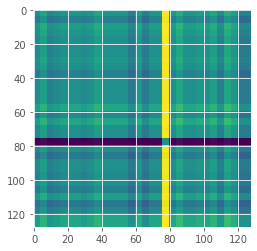

In [15]:
print("Loading GAF images (train)...")
gaf_images = []
yh3_train = []
for path in tqdm(glob( os.path.join(BENCHMARKING2_RESOURCES_PATH, "GeneratedImages", "*_PAA_GADF_train_*.png") )):    
    # GADF...
    img = keras_image.load_img( path, target_size=(128, 128 ,3))
    img = keras_image.img_to_array(img)
    img = img/255
    gaf_images.append(img)
    # Labels...
    image_labels = [int(l) for l in list(path.split("\\")[-1].split(".")[0].split("_")[-1])]
    yh3_train.append(image_labels)
    
Xh3_train = np.array(gaf_images)
yh3_train = np.array(yh3_train)

print(Xh3_train.shape)
plt.imshow(Xh3_train[88])

print(yh3_train[88])

Loading GAF images (test)...


100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:02<00:00, 1708.86it/s]


(4000, 128, 128, 3)
[0 0 0 0 0 0 0 0 0]


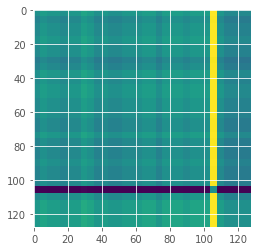

In [16]:
print("Loading GAF images (test)...")
gaf_images = []
yh3_test = []
for path in tqdm(glob( os.path.join(BENCHMARKING2_RESOURCES_PATH, "GeneratedImages", "*_PAA_GADF_test_*.png") )):    
    # GADF...
    img = keras_image.load_img( path, target_size=(128, 128 ,3))
    img = keras_image.img_to_array(img)
    img = img/255
    gaf_images.append(img)
    # Labels...
    image_labels = [int(l) for l in list(path.split("\\")[-1].split(".")[0].split("_")[-1])]
    yh3_test.append(image_labels)
    
Xh3_test = np.array(gaf_images)
yh3_test = np.array(yh3_test)

print(Xh3_test.shape)
plt.imshow(Xh3_test[88])

print(yh3_test[88])

In [17]:
model_h3 = Sequential()

model_h3.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(128,128,3)))
model_h3.add(MaxPooling2D(pool_size=(2, 2)))
model_h3.add(Dropout(0.25))
model_h3.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model_h3.add(MaxPooling2D(pool_size=(2, 2)))
model_h3.add(Dropout(0.25))
model_h3.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model_h3.add(MaxPooling2D(pool_size=(2, 2)))
model_h3.add(Dropout(0.25))
model_h3.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model_h3.add(MaxPooling2D(pool_size=(2, 2)))
model_h3.add(Dropout(0.25))
model_h3.add(Flatten())
model_h3.add(Dense(128, activation='relu'))
model_h3.add(Dropout(0.5))
model_h3.add(Dense(64, activation='relu'))
model_h3.add(Dropout(0.5))

model_h3.add(Dense(9, activation='sigmoid'))

model_h3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m])

model_h3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        5

In [18]:
# Model fit...
print("Training the model...")
callback = model_h3.fit(
    Xh3_train, yh3_train,
    validation_data=(Xh3_test, yh3_test), 
    epochs=100, batch_size=32,
    verbose = 1#, callbacks = [tqdm_callback]
)

Training the model...


W1012 11:30:12.889883  9700 deprecation.py:323] From C:\Users\diego\anaconda3\envs\doutorado\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 [==============================] - ETA: 5:40 - loss: 0.8013 - acc: 0.4826 - f1_m: 0.23 - ETA: 2:52 - loss: 0.7201 - acc: 0.5729 - f1_m: 0.33 - ETA: 1:27 - loss: 0.6441 - acc: 0.6510 - f1_m: 0.35 - ETA: 58s - loss: 0.5975 - acc: 0.6794 - f1_m: 0.3616 - ETA: 44s - loss: 0.5610 - acc: 0.7118 - f1_m: 0.382 - ETA: 35s - loss: 0.5323 - acc: 0.7326 - f1_m: 0.408 - ETA: 29s - loss: 0.5084 - acc: 0.7488 - f1_m: 0.417 - ETA: 25s - loss: 0.4919 - acc: 0.7599 - f1_m: 0.411 - ETA: 22s - loss: 0.4797 - acc: 0.7700 - f1_m: 0.421 - ETA: 20s - loss: 0.4667 - acc: 0.7766 - f1_m: 0.422 - ETA: 18s - loss: 0.4587 - acc: 0.7818 - f1_m: 0.418 - ETA: 16s - loss: 0.4476 - acc: 0.7891 - f1_m: 0.426 - ETA: 15s - loss: 0.4417 - acc: 0.7935 - f1_m: 0.422 - ETA: 13s - loss: 0.4338 - acc: 0.7983 - f1_m: 0.423 - ETA: 12s - loss: 0.4262 - acc: 0.8030 - f1_m: 0.430 - ETA: 12s - loss: 0.4192 - acc: 0.8076 - f1_m: 0.436 - ETA: 11s - loss: 0.4167 - acc:

4000/4000 [==============================] - ETA: 4s - loss: 0.2850 - acc: 0.8819 - f1_m: 0.46 - ETA: 4s - loss: 0.2612 - acc: 0.8773 - f1_m: 0.44 - ETA: 4s - loss: 0.2798 - acc: 0.8750 - f1_m: 0.41 - ETA: 4s - loss: 0.2847 - acc: 0.8720 - f1_m: 0.39 - ETA: 4s - loss: 0.2854 - acc: 0.8696 - f1_m: 0.39 - ETA: 3s - loss: 0.2788 - acc: 0.8747 - f1_m: 0.41 - ETA: 3s - loss: 0.2794 - acc: 0.8718 - f1_m: 0.39 - ETA: 3s - loss: 0.2758 - acc: 0.8713 - f1_m: 0.39 - ETA: 3s - loss: 0.2705 - acc: 0.8734 - f1_m: 0.40 - ETA: 3s - loss: 0.2692 - acc: 0.8755 - f1_m: 0.42 - ETA: 3s - loss: 0.2707 - acc: 0.8758 - f1_m: 0.42 - ETA: 3s - loss: 0.2672 - acc: 0.8777 - f1_m: 0.42 - ETA: 3s - loss: 0.2681 - acc: 0.8783 - f1_m: 0.43 - ETA: 3s - loss: 0.2669 - acc: 0.8782 - f1_m: 0.43 - ETA: 3s - loss: 0.2670 - acc: 0.8780 - f1_m: 0.43 - ETA: 3s - loss: 0.2644 - acc: 0.8777 - f1_m: 0.43 - ETA: 3s - loss: 0.2631 - acc: 0.8778 - f1_m: 0.43 - ETA: 3s - loss: 0.2635 - acc: 0.8778 - f1_m: 0.43 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2439 - acc: 0.8924 - f1_m: 0.41 - ETA: 4s - loss: 0.2660 - acc: 0.8924 - f1_m: 0.46 - ETA: 4s - loss: 0.2564 - acc: 0.8958 - f1_m: 0.51 - ETA: 4s - loss: 0.2581 - acc: 0.8869 - f1_m: 0.48 - ETA: 4s - loss: 0.2459 - acc: 0.8885 - f1_m: 0.48 - ETA: 4s - loss: 0.2424 - acc: 0.8857 - f1_m: 0.47 - ETA: 3s - loss: 0.2458 - acc: 0.8851 - f1_m: 0.47 - ETA: 3s - loss: 0.2438 - acc: 0.8845 - f1_m: 0.47 - ETA: 3s - loss: 0.2473 - acc: 0.8844 - f1_m: 0.47 - ETA: 3s - loss: 0.2456 - acc: 0.8872 - f1_m: 0.49 - ETA: 3s - loss: 0.2495 - acc: 0.8848 - f1_m: 0.48 - ETA: 3s - loss: 0.2470 - acc: 0.8844 - f1_m: 0.48 - ETA: 3s - loss: 0.2498 - acc: 0.8833 - f1_m: 0.48 - ETA: 3s - loss: 0.2517 - acc: 0.8836 - f1_m: 0.48 - ETA: 3s - loss: 0.2525 - acc: 0.8834 - f1_m: 0.48 - ETA: 3s - loss: 0.2522 - acc: 0.8836 - f1_m: 0.48 - ETA: 3s - loss: 0.2508 - acc: 0.8842 - f1_m: 0.49 - ETA: 3s - loss: 0.2507 - acc: 0.8843 - f1_m: 0.48 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2258 - acc: 0.8715 - f1_m: 0.44 - ETA: 4s - loss: 0.2457 - acc: 0.8843 - f1_m: 0.49 - ETA: 4s - loss: 0.2308 - acc: 0.8882 - f1_m: 0.48 - ETA: 4s - loss: 0.2313 - acc: 0.8899 - f1_m: 0.48 - ETA: 4s - loss: 0.2325 - acc: 0.8931 - f1_m: 0.48 - ETA: 4s - loss: 0.2305 - acc: 0.8927 - f1_m: 0.49 - ETA: 4s - loss: 0.2331 - acc: 0.8905 - f1_m: 0.49 - ETA: 4s - loss: 0.2369 - acc: 0.8880 - f1_m: 0.49 - ETA: 3s - loss: 0.2348 - acc: 0.8881 - f1_m: 0.48 - ETA: 3s - loss: 0.2377 - acc: 0.8885 - f1_m: 0.49 - ETA: 3s - loss: 0.2370 - acc: 0.8886 - f1_m: 0.49 - ETA: 3s - loss: 0.2387 - acc: 0.8889 - f1_m: 0.50 - ETA: 3s - loss: 0.2390 - acc: 0.8889 - f1_m: 0.50 - ETA: 3s - loss: 0.2399 - acc: 0.8876 - f1_m: 0.50 - ETA: 3s - loss: 0.2421 - acc: 0.8878 - f1_m: 0.50 - ETA: 3s - loss: 0.2444 - acc: 0.8869 - f1_m: 0.50 - ETA: 3s - loss: 0.2433 - acc: 0.8873 - f1_m: 0.50 - ETA: 3s - loss: 0.2439 - acc: 0.8864 - f1_m: 0.50 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.3446 - acc: 0.8507 - f1_m: 0.55 - ETA: 4s - loss: 0.2684 - acc: 0.8762 - f1_m: 0.56 - ETA: 4s - loss: 0.2705 - acc: 0.8792 - f1_m: 0.57 - ETA: 4s - loss: 0.2527 - acc: 0.8854 - f1_m: 0.58 - ETA: 4s - loss: 0.2458 - acc: 0.8885 - f1_m: 0.58 - ETA: 4s - loss: 0.2483 - acc: 0.8848 - f1_m: 0.55 - ETA: 4s - loss: 0.2490 - acc: 0.8825 - f1_m: 0.53 - ETA: 3s - loss: 0.2437 - acc: 0.8847 - f1_m: 0.54 - ETA: 3s - loss: 0.2400 - acc: 0.8846 - f1_m: 0.53 - ETA: 3s - loss: 0.2399 - acc: 0.8841 - f1_m: 0.53 - ETA: 3s - loss: 0.2403 - acc: 0.8861 - f1_m: 0.54 - ETA: 3s - loss: 0.2351 - acc: 0.8890 - f1_m: 0.54 - ETA: 3s - loss: 0.2332 - acc: 0.8902 - f1_m: 0.55 - ETA: 3s - loss: 0.2349 - acc: 0.8906 - f1_m: 0.55 - ETA: 3s - loss: 0.2374 - acc: 0.8895 - f1_m: 0.54 - ETA: 3s - loss: 0.2378 - acc: 0.8888 - f1_m: 0.54 - ETA: 3s - loss: 0.2374 - acc: 0.8889 - f1_m: 0.54 - ETA: 3s - loss: 0.2374 - acc: 0.8889 - f1_m: 0.54 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2578 - acc: 0.8958 - f1_m: 0.51 - ETA: 4s - loss: 0.2583 - acc: 0.8785 - f1_m: 0.48 - ETA: 4s - loss: 0.2451 - acc: 0.8806 - f1_m: 0.48 - ETA: 4s - loss: 0.2433 - acc: 0.8864 - f1_m: 0.51 - ETA: 4s - loss: 0.2439 - acc: 0.8862 - f1_m: 0.52 - ETA: 4s - loss: 0.2449 - acc: 0.8845 - f1_m: 0.51 - ETA: 4s - loss: 0.2424 - acc: 0.8851 - f1_m: 0.51 - ETA: 3s - loss: 0.2388 - acc: 0.8859 - f1_m: 0.51 - ETA: 3s - loss: 0.2357 - acc: 0.8877 - f1_m: 0.51 - ETA: 3s - loss: 0.2338 - acc: 0.8893 - f1_m: 0.52 - ETA: 3s - loss: 0.2326 - acc: 0.8902 - f1_m: 0.52 - ETA: 3s - loss: 0.2335 - acc: 0.8901 - f1_m: 0.52 - ETA: 3s - loss: 0.2335 - acc: 0.8908 - f1_m: 0.53 - ETA: 3s - loss: 0.2361 - acc: 0.8908 - f1_m: 0.54 - ETA: 3s - loss: 0.2349 - acc: 0.8919 - f1_m: 0.54 - ETA: 3s - loss: 0.2326 - acc: 0.8928 - f1_m: 0.55 - ETA: 3s - loss: 0.2333 - acc: 0.8924 - f1_m: 0.55 - ETA: 3s - loss: 0.2326 - acc: 0.8921 - f1_m: 0.54 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2357 - acc: 0.8924 - f1_m: 0.55 - ETA: 4s - loss: 0.2201 - acc: 0.9039 - f1_m: 0.58 - ETA: 4s - loss: 0.2302 - acc: 0.8903 - f1_m: 0.54 - ETA: 4s - loss: 0.2395 - acc: 0.8824 - f1_m: 0.51 - ETA: 3s - loss: 0.2396 - acc: 0.8854 - f1_m: 0.53 - ETA: 3s - loss: 0.2359 - acc: 0.8867 - f1_m: 0.53 - ETA: 3s - loss: 0.2311 - acc: 0.8905 - f1_m: 0.54 - ETA: 3s - loss: 0.2289 - acc: 0.8914 - f1_m: 0.54 - ETA: 3s - loss: 0.2295 - acc: 0.8930 - f1_m: 0.55 - ETA: 3s - loss: 0.2298 - acc: 0.8927 - f1_m: 0.55 - ETA: 3s - loss: 0.2281 - acc: 0.8932 - f1_m: 0.55 - ETA: 3s - loss: 0.2316 - acc: 0.8925 - f1_m: 0.55 - ETA: 3s - loss: 0.2304 - acc: 0.8931 - f1_m: 0.55 - ETA: 3s - loss: 0.2296 - acc: 0.8949 - f1_m: 0.56 - ETA: 3s - loss: 0.2288 - acc: 0.8957 - f1_m: 0.56 - ETA: 3s - loss: 0.2294 - acc: 0.8946 - f1_m: 0.56 - ETA: 3s - loss: 0.2304 - acc: 0.8938 - f1_m: 0.56 - ETA: 3s - loss: 0.2281 - acc: 0.8941 - f1_m: 0.56 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2577 - acc: 0.8889 - f1_m: 0.60 - ETA: 4s - loss: 0.2279 - acc: 0.9005 - f1_m: 0.61 - ETA: 4s - loss: 0.2308 - acc: 0.8979 - f1_m: 0.62 - ETA: 4s - loss: 0.2349 - acc: 0.8948 - f1_m: 0.62 - ETA: 4s - loss: 0.2331 - acc: 0.8974 - f1_m: 0.63 - ETA: 4s - loss: 0.2366 - acc: 0.8943 - f1_m: 0.61 - ETA: 3s - loss: 0.2350 - acc: 0.8929 - f1_m: 0.60 - ETA: 3s - loss: 0.2350 - acc: 0.8949 - f1_m: 0.61 - ETA: 3s - loss: 0.2320 - acc: 0.8954 - f1_m: 0.61 - ETA: 3s - loss: 0.2317 - acc: 0.8973 - f1_m: 0.62 - ETA: 3s - loss: 0.2324 - acc: 0.8967 - f1_m: 0.61 - ETA: 3s - loss: 0.2298 - acc: 0.8963 - f1_m: 0.61 - ETA: 3s - loss: 0.2288 - acc: 0.8967 - f1_m: 0.61 - ETA: 3s - loss: 0.2272 - acc: 0.8970 - f1_m: 0.61 - ETA: 3s - loss: 0.2268 - acc: 0.8968 - f1_m: 0.60 - ETA: 3s - loss: 0.2292 - acc: 0.8964 - f1_m: 0.60 - ETA: 3s - loss: 0.2300 - acc: 0.8970 - f1_m: 0.61 - ETA: 3s - loss: 0.2293 - acc: 0.8964 - f1_m: 0.60 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2356 - acc: 0.8993 - f1_m: 0.59 - ETA: 4s - loss: 0.2310 - acc: 0.8958 - f1_m: 0.57 - ETA: 4s - loss: 0.2424 - acc: 0.8910 - f1_m: 0.54 - ETA: 4s - loss: 0.2477 - acc: 0.8889 - f1_m: 0.55 - ETA: 4s - loss: 0.2414 - acc: 0.8881 - f1_m: 0.54 - ETA: 3s - loss: 0.2431 - acc: 0.8845 - f1_m: 0.53 - ETA: 3s - loss: 0.2386 - acc: 0.8854 - f1_m: 0.53 - ETA: 3s - loss: 0.2398 - acc: 0.8873 - f1_m: 0.55 - ETA: 3s - loss: 0.2391 - acc: 0.8877 - f1_m: 0.55 - ETA: 3s - loss: 0.2359 - acc: 0.8887 - f1_m: 0.53 - ETA: 3s - loss: 0.2361 - acc: 0.8887 - f1_m: 0.53 - ETA: 3s - loss: 0.2358 - acc: 0.8887 - f1_m: 0.52 - ETA: 3s - loss: 0.2370 - acc: 0.8883 - f1_m: 0.52 - ETA: 3s - loss: 0.2355 - acc: 0.8893 - f1_m: 0.52 - ETA: 3s - loss: 0.2335 - acc: 0.8897 - f1_m: 0.53 - ETA: 3s - loss: 0.2338 - acc: 0.8897 - f1_m: 0.53 - ETA: 3s - loss: 0.2319 - acc: 0.8893 - f1_m: 0.52 - ETA: 3s - loss: 0.2299 - acc: 0.8912 - f1_m: 0.52 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2016 - acc: 0.9132 - f1_m: 0.65 - ETA: 4s - loss: 0.2151 - acc: 0.9016 - f1_m: 0.59 - ETA: 4s - loss: 0.2328 - acc: 0.8958 - f1_m: 0.59 - ETA: 4s - loss: 0.2251 - acc: 0.8978 - f1_m: 0.59 - ETA: 4s - loss: 0.2193 - acc: 0.9001 - f1_m: 0.59 - ETA: 4s - loss: 0.2192 - acc: 0.8996 - f1_m: 0.58 - ETA: 4s - loss: 0.2214 - acc: 0.8985 - f1_m: 0.57 - ETA: 3s - loss: 0.2219 - acc: 0.8984 - f1_m: 0.57 - ETA: 3s - loss: 0.2205 - acc: 0.8997 - f1_m: 0.58 - ETA: 3s - loss: 0.2207 - acc: 0.9017 - f1_m: 0.59 - ETA: 3s - loss: 0.2192 - acc: 0.9018 - f1_m: 0.59 - ETA: 3s - loss: 0.2174 - acc: 0.9034 - f1_m: 0.60 - ETA: 3s - loss: 0.2163 - acc: 0.9031 - f1_m: 0.60 - ETA: 3s - loss: 0.2166 - acc: 0.9019 - f1_m: 0.60 - ETA: 3s - loss: 0.2179 - acc: 0.9018 - f1_m: 0.60 - ETA: 3s - loss: 0.2174 - acc: 0.9019 - f1_m: 0.60 - ETA: 3s - loss: 0.2196 - acc: 0.9000 - f1_m: 0.59 - ETA: 3s - loss: 0.2224 - acc: 0.8988 - f1_m: 0.59 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2252 - acc: 0.8750 - f1_m: 0.47 - ETA: 4s - loss: 0.2156 - acc: 0.8900 - f1_m: 0.51 - ETA: 4s - loss: 0.2185 - acc: 0.8944 - f1_m: 0.56 - ETA: 4s - loss: 0.2071 - acc: 0.8998 - f1_m: 0.58 - ETA: 4s - loss: 0.2164 - acc: 0.8970 - f1_m: 0.57 - ETA: 4s - loss: 0.2208 - acc: 0.8965 - f1_m: 0.57 - ETA: 3s - loss: 0.2185 - acc: 0.8977 - f1_m: 0.57 - ETA: 3s - loss: 0.2196 - acc: 0.8979 - f1_m: 0.57 - ETA: 3s - loss: 0.2211 - acc: 0.8952 - f1_m: 0.56 - ETA: 3s - loss: 0.2221 - acc: 0.8951 - f1_m: 0.56 - ETA: 3s - loss: 0.2227 - acc: 0.8955 - f1_m: 0.57 - ETA: 3s - loss: 0.2217 - acc: 0.8961 - f1_m: 0.57 - ETA: 3s - loss: 0.2200 - acc: 0.8979 - f1_m: 0.57 - ETA: 3s - loss: 0.2215 - acc: 0.8976 - f1_m: 0.57 - ETA: 3s - loss: 0.2184 - acc: 0.8981 - f1_m: 0.57 - ETA: 3s - loss: 0.2179 - acc: 0.8984 - f1_m: 0.57 - ETA: 3s - loss: 0.2174 - acc: 0.8984 - f1_m: 0.57 - ETA: 3s - loss: 0.2198 - acc: 0.8974 - f1_m: 0.56 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2022 - acc: 0.8785 - f1_m: 0.44 - ETA: 4s - loss: 0.2043 - acc: 0.8993 - f1_m: 0.58 - ETA: 4s - loss: 0.2119 - acc: 0.8993 - f1_m: 0.59 - ETA: 4s - loss: 0.2041 - acc: 0.8983 - f1_m: 0.57 - ETA: 4s - loss: 0.2105 - acc: 0.8954 - f1_m: 0.57 - ETA: 4s - loss: 0.2061 - acc: 0.8980 - f1_m: 0.56 - ETA: 3s - loss: 0.2159 - acc: 0.8948 - f1_m: 0.55 - ETA: 3s - loss: 0.2177 - acc: 0.8924 - f1_m: 0.55 - ETA: 3s - loss: 0.2177 - acc: 0.8940 - f1_m: 0.56 - ETA: 3s - loss: 0.2210 - acc: 0.8924 - f1_m: 0.55 - ETA: 3s - loss: 0.2225 - acc: 0.8924 - f1_m: 0.56 - ETA: 3s - loss: 0.2194 - acc: 0.8937 - f1_m: 0.56 - ETA: 3s - loss: 0.2226 - acc: 0.8922 - f1_m: 0.56 - ETA: 3s - loss: 0.2243 - acc: 0.8916 - f1_m: 0.56 - ETA: 3s - loss: 0.2234 - acc: 0.8909 - f1_m: 0.55 - ETA: 3s - loss: 0.2216 - acc: 0.8922 - f1_m: 0.56 - ETA: 3s - loss: 0.2210 - acc: 0.8927 - f1_m: 0.57 - ETA: 3s - loss: 0.2207 - acc: 0.8940 - f1_m: 0.57 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2109 - acc: 0.9062 - f1_m: 0.63 - ETA: 5s - loss: 0.1879 - acc: 0.9184 - f1_m: 0.62 - ETA: 4s - loss: 0.1984 - acc: 0.9054 - f1_m: 0.59 - ETA: 4s - loss: 0.2039 - acc: 0.8993 - f1_m: 0.55 - ETA: 4s - loss: 0.2056 - acc: 0.8958 - f1_m: 0.54 - ETA: 4s - loss: 0.2108 - acc: 0.8976 - f1_m: 0.55 - ETA: 4s - loss: 0.2119 - acc: 0.8961 - f1_m: 0.55 - ETA: 4s - loss: 0.2122 - acc: 0.8971 - f1_m: 0.55 - ETA: 4s - loss: 0.2150 - acc: 0.8954 - f1_m: 0.55 - ETA: 3s - loss: 0.2169 - acc: 0.8960 - f1_m: 0.56 - ETA: 3s - loss: 0.2168 - acc: 0.8958 - f1_m: 0.57 - ETA: 3s - loss: 0.2146 - acc: 0.8966 - f1_m: 0.57 - ETA: 3s - loss: 0.2131 - acc: 0.8977 - f1_m: 0.58 - ETA: 3s - loss: 0.2143 - acc: 0.8964 - f1_m: 0.58 - ETA: 3s - loss: 0.2150 - acc: 0.8956 - f1_m: 0.58 - ETA: 3s - loss: 0.2151 - acc: 0.8959 - f1_m: 0.58 - ETA: 3s - loss: 0.2134 - acc: 0.8962 - f1_m: 0.58 - ETA: 3s - loss: 0.2122 - acc: 0.8965 - f1_m: 0.58 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.1984 - acc: 0.8993 - f1_m: 0.49 - ETA: 4s - loss: 0.1841 - acc: 0.9120 - f1_m: 0.57 - ETA: 4s - loss: 0.1826 - acc: 0.9125 - f1_m: 0.58 - ETA: 4s - loss: 0.1878 - acc: 0.9067 - f1_m: 0.56 - ETA: 4s - loss: 0.1930 - acc: 0.9070 - f1_m: 0.56 - ETA: 4s - loss: 0.1968 - acc: 0.9056 - f1_m: 0.57 - ETA: 3s - loss: 0.1996 - acc: 0.9054 - f1_m: 0.58 - ETA: 3s - loss: 0.2004 - acc: 0.9051 - f1_m: 0.59 - ETA: 3s - loss: 0.2015 - acc: 0.9040 - f1_m: 0.60 - ETA: 3s - loss: 0.2010 - acc: 0.9042 - f1_m: 0.60 - ETA: 3s - loss: 0.2035 - acc: 0.9034 - f1_m: 0.59 - ETA: 3s - loss: 0.2044 - acc: 0.9019 - f1_m: 0.58 - ETA: 3s - loss: 0.2030 - acc: 0.9024 - f1_m: 0.58 - ETA: 3s - loss: 0.2033 - acc: 0.9024 - f1_m: 0.58 - ETA: 3s - loss: 0.2027 - acc: 0.9027 - f1_m: 0.58 - ETA: 3s - loss: 0.2042 - acc: 0.9017 - f1_m: 0.58 - ETA: 3s - loss: 0.2051 - acc: 0.9011 - f1_m: 0.58 - ETA: 3s - loss: 0.2060 - acc: 0.8998 - f1_m: 0.57 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.1843 - acc: 0.8958 - f1_m: 0.53 - ETA: 4s - loss: 0.2044 - acc: 0.8900 - f1_m: 0.55 - ETA: 4s - loss: 0.2066 - acc: 0.9000 - f1_m: 0.62 - ETA: 4s - loss: 0.2102 - acc: 0.9003 - f1_m: 0.61 - ETA: 4s - loss: 0.2103 - acc: 0.9001 - f1_m: 0.60 - ETA: 3s - loss: 0.2124 - acc: 0.8999 - f1_m: 0.60 - ETA: 3s - loss: 0.2206 - acc: 0.8977 - f1_m: 0.60 - ETA: 3s - loss: 0.2164 - acc: 0.9000 - f1_m: 0.61 - ETA: 3s - loss: 0.2136 - acc: 0.9005 - f1_m: 0.61 - ETA: 3s - loss: 0.2138 - acc: 0.8997 - f1_m: 0.60 - ETA: 3s - loss: 0.2141 - acc: 0.8981 - f1_m: 0.60 - ETA: 3s - loss: 0.2132 - acc: 0.8979 - f1_m: 0.59 - ETA: 3s - loss: 0.2139 - acc: 0.8978 - f1_m: 0.59 - ETA: 3s - loss: 0.2134 - acc: 0.8979 - f1_m: 0.59 - ETA: 3s - loss: 0.2130 - acc: 0.8977 - f1_m: 0.59 - ETA: 3s - loss: 0.2145 - acc: 0.8976 - f1_m: 0.59 - ETA: 3s - loss: 0.2122 - acc: 0.8983 - f1_m: 0.59 - ETA: 3s - loss: 0.2133 - acc: 0.8979 - f1_m: 0.58 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.1857 - acc: 0.9167 - f1_m: 0.63 - ETA: 4s - loss: 0.2219 - acc: 0.9016 - f1_m: 0.58 - ETA: 4s - loss: 0.2144 - acc: 0.8993 - f1_m: 0.59 - ETA: 4s - loss: 0.2116 - acc: 0.8993 - f1_m: 0.58 - ETA: 4s - loss: 0.2081 - acc: 0.9012 - f1_m: 0.58 - ETA: 4s - loss: 0.2078 - acc: 0.9021 - f1_m: 0.59 - ETA: 4s - loss: 0.2088 - acc: 0.9020 - f1_m: 0.59 - ETA: 3s - loss: 0.2081 - acc: 0.8995 - f1_m: 0.58 - ETA: 3s - loss: 0.2086 - acc: 0.8997 - f1_m: 0.59 - ETA: 3s - loss: 0.2086 - acc: 0.9006 - f1_m: 0.59 - ETA: 3s - loss: 0.2097 - acc: 0.9006 - f1_m: 0.59 - ETA: 3s - loss: 0.2096 - acc: 0.9011 - f1_m: 0.59 - ETA: 3s - loss: 0.2090 - acc: 0.9000 - f1_m: 0.58 - ETA: 3s - loss: 0.2105 - acc: 0.8988 - f1_m: 0.58 - ETA: 3s - loss: 0.2109 - acc: 0.8995 - f1_m: 0.59 - ETA: 3s - loss: 0.2101 - acc: 0.8996 - f1_m: 0.59 - ETA: 3s - loss: 0.2096 - acc: 0.8994 - f1_m: 0.59 - ETA: 3s - loss: 0.2098 - acc: 0.8989 - f1_m: 0.59 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 5s - loss: 0.2536 - acc: 0.8785 - f1_m: 0.40 - ETA: 4s - loss: 0.2206 - acc: 0.8900 - f1_m: 0.50 - ETA: 4s - loss: 0.2161 - acc: 0.8965 - f1_m: 0.54 - ETA: 4s - loss: 0.2134 - acc: 0.8968 - f1_m: 0.54 - ETA: 4s - loss: 0.2104 - acc: 0.8993 - f1_m: 0.56 - ETA: 4s - loss: 0.2047 - acc: 0.9018 - f1_m: 0.57 - ETA: 3s - loss: 0.2039 - acc: 0.9014 - f1_m: 0.57 - ETA: 3s - loss: 0.2016 - acc: 0.9021 - f1_m: 0.57 - ETA: 3s - loss: 0.2005 - acc: 0.9046 - f1_m: 0.58 - ETA: 3s - loss: 0.2001 - acc: 0.9053 - f1_m: 0.58 - ETA: 3s - loss: 0.1975 - acc: 0.9072 - f1_m: 0.59 - ETA: 3s - loss: 0.1956 - acc: 0.9079 - f1_m: 0.59 - ETA: 3s - loss: 0.1925 - acc: 0.9090 - f1_m: 0.60 - ETA: 3s - loss: 0.1923 - acc: 0.9095 - f1_m: 0.60 - ETA: 3s - loss: 0.1932 - acc: 0.9085 - f1_m: 0.60 - ETA: 3s - loss: 0.1974 - acc: 0.9074 - f1_m: 0.60 - ETA: 3s - loss: 0.1993 - acc: 0.9072 - f1_m: 0.60 - ETA: 3s - loss: 0.2007 - acc: 0.9062 - f1_m: 0.60 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.1724 - acc: 0.9132 - f1_m: 0.62 - ETA: 4s - loss: 0.2000 - acc: 0.9039 - f1_m: 0.60 - ETA: 4s - loss: 0.1979 - acc: 0.9042 - f1_m: 0.60 - ETA: 4s - loss: 0.2068 - acc: 0.8988 - f1_m: 0.58 - ETA: 4s - loss: 0.1988 - acc: 0.9039 - f1_m: 0.59 - ETA: 4s - loss: 0.2016 - acc: 0.9025 - f1_m: 0.59 - ETA: 4s - loss: 0.2029 - acc: 0.9041 - f1_m: 0.60 - ETA: 4s - loss: 0.2008 - acc: 0.9056 - f1_m: 0.61 - ETA: 3s - loss: 0.2018 - acc: 0.9054 - f1_m: 0.61 - ETA: 3s - loss: 0.2043 - acc: 0.9028 - f1_m: 0.61 - ETA: 3s - loss: 0.2018 - acc: 0.9036 - f1_m: 0.61 - ETA: 3s - loss: 0.2001 - acc: 0.9044 - f1_m: 0.61 - ETA: 3s - loss: 0.2008 - acc: 0.9044 - f1_m: 0.61 - ETA: 3s - loss: 0.2034 - acc: 0.9032 - f1_m: 0.61 - ETA: 3s - loss: 0.2037 - acc: 0.9033 - f1_m: 0.61 - ETA: 3s - loss: 0.2030 - acc: 0.9036 - f1_m: 0.61 - ETA: 3s - loss: 0.2029 - acc: 0.9037 - f1_m: 0.61 - ETA: 3s - loss: 0.2021 - acc: 0.9044 - f1_m: 0.62 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 5s - loss: 0.2576 - acc: 0.8785 - f1_m: 0.55 - ETA: 4s - loss: 0.2165 - acc: 0.8924 - f1_m: 0.58 - ETA: 4s - loss: 0.2086 - acc: 0.8938 - f1_m: 0.58 - ETA: 4s - loss: 0.2039 - acc: 0.8993 - f1_m: 0.60 - ETA: 4s - loss: 0.1978 - acc: 0.9020 - f1_m: 0.59 - ETA: 4s - loss: 0.1956 - acc: 0.9044 - f1_m: 0.60 - ETA: 4s - loss: 0.1956 - acc: 0.9057 - f1_m: 0.60 - ETA: 4s - loss: 0.1946 - acc: 0.9075 - f1_m: 0.61 - ETA: 4s - loss: 0.1996 - acc: 0.9065 - f1_m: 0.61 - ETA: 4s - loss: 0.2024 - acc: 0.9047 - f1_m: 0.62 - ETA: 3s - loss: 0.2020 - acc: 0.9062 - f1_m: 0.62 - ETA: 3s - loss: 0.2003 - acc: 0.9074 - f1_m: 0.63 - ETA: 3s - loss: 0.2004 - acc: 0.9073 - f1_m: 0.63 - ETA: 3s - loss: 0.2021 - acc: 0.9069 - f1_m: 0.63 - ETA: 3s - loss: 0.1998 - acc: 0.9080 - f1_m: 0.63 - ETA: 3s - loss: 0.2014 - acc: 0.9071 - f1_m: 0.63 - ETA: 3s - loss: 0.2019 - acc: 0.9069 - f1_m: 0.63 - ETA: 3s - loss: 0.2012 - acc: 0.9062 - f1_m: 0.63 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.1493 - acc: 0.9236 - f1_m: 0.68 - ETA: 4s - loss: 0.1906 - acc: 0.9167 - f1_m: 0.64 - ETA: 4s - loss: 0.1901 - acc: 0.9187 - f1_m: 0.64 - ETA: 4s - loss: 0.1924 - acc: 0.9172 - f1_m: 0.64 - ETA: 4s - loss: 0.1955 - acc: 0.9136 - f1_m: 0.64 - ETA: 4s - loss: 0.1929 - acc: 0.9141 - f1_m: 0.64 - ETA: 3s - loss: 0.1938 - acc: 0.9108 - f1_m: 0.62 - ETA: 3s - loss: 0.1895 - acc: 0.9130 - f1_m: 0.63 - ETA: 3s - loss: 0.1929 - acc: 0.9140 - f1_m: 0.64 - ETA: 3s - loss: 0.1949 - acc: 0.9119 - f1_m: 0.63 - ETA: 3s - loss: 0.1916 - acc: 0.9134 - f1_m: 0.64 - ETA: 3s - loss: 0.1896 - acc: 0.9138 - f1_m: 0.64 - ETA: 3s - loss: 0.1890 - acc: 0.9131 - f1_m: 0.63 - ETA: 3s - loss: 0.1893 - acc: 0.9111 - f1_m: 0.62 - ETA: 3s - loss: 0.1905 - acc: 0.9112 - f1_m: 0.62 - ETA: 3s - loss: 0.1911 - acc: 0.9099 - f1_m: 0.62 - ETA: 3s - loss: 0.1907 - acc: 0.9104 - f1_m: 0.62 - ETA: 3s - loss: 0.1893 - acc: 0.9102 - f1_m: 0.62 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.2351 - acc: 0.8993 - f1_m: 0.65 - ETA: 4s - loss: 0.2135 - acc: 0.9016 - f1_m: 0.60 - ETA: 4s - loss: 0.1992 - acc: 0.9090 - f1_m: 0.63 - ETA: 4s - loss: 0.1988 - acc: 0.9087 - f1_m: 0.64 - ETA: 4s - loss: 0.1990 - acc: 0.9078 - f1_m: 0.63 - ETA: 4s - loss: 0.2019 - acc: 0.9062 - f1_m: 0.63 - ETA: 4s - loss: 0.1993 - acc: 0.9084 - f1_m: 0.64 - ETA: 4s - loss: 0.1995 - acc: 0.9074 - f1_m: 0.64 - ETA: 4s - loss: 0.1993 - acc: 0.9071 - f1_m: 0.64 - ETA: 3s - loss: 0.1998 - acc: 0.9075 - f1_m: 0.64 - ETA: 3s - loss: 0.2006 - acc: 0.9076 - f1_m: 0.64 - ETA: 3s - loss: 0.2008 - acc: 0.9062 - f1_m: 0.62 - ETA: 3s - loss: 0.2000 - acc: 0.9062 - f1_m: 0.62 - ETA: 3s - loss: 0.2007 - acc: 0.9057 - f1_m: 0.62 - ETA: 3s - loss: 0.1995 - acc: 0.9058 - f1_m: 0.62 - ETA: 3s - loss: 0.1997 - acc: 0.9056 - f1_m: 0.62 - ETA: 3s - loss: 0.1975 - acc: 0.9065 - f1_m: 0.62 - ETA: 3s - loss: 0.1957 - acc: 0.9072 - f1_m: 0.62 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1549 - acc: 0.9236 - f1_m: 0.66 - ETA: 4s - loss: 0.1523 - acc: 0.9213 - f1_m: 0.65 - ETA: 4s - loss: 0.1623 - acc: 0.9215 - f1_m: 0.65 - ETA: 4s - loss: 0.1663 - acc: 0.9196 - f1_m: 0.64 - ETA: 4s - loss: 0.1702 - acc: 0.9213 - f1_m: 0.66 - ETA: 4s - loss: 0.1697 - acc: 0.9214 - f1_m: 0.66 - ETA: 4s - loss: 0.1691 - acc: 0.9225 - f1_m: 0.66 - ETA: 4s - loss: 0.1708 - acc: 0.9204 - f1_m: 0.65 - ETA: 4s - loss: 0.1723 - acc: 0.9199 - f1_m: 0.64 - ETA: 4s - loss: 0.1723 - acc: 0.9207 - f1_m: 0.64 - ETA: 4s - loss: 0.1753 - acc: 0.9190 - f1_m: 0.64 - ETA: 3s - loss: 0.1747 - acc: 0.9186 - f1_m: 0.63 - ETA: 3s - loss: 0.1753 - acc: 0.9174 - f1_m: 0.63 - ETA: 3s - loss: 0.1744 - acc: 0.9183 - f1_m: 0.63 - ETA: 3s - loss: 0.1745 - acc: 0.9177 - f1_m: 0.63 - ETA: 3s - loss: 0.1728 - acc: 0.9182 - f1_m: 0.63 - ETA: 3s - loss: 0.1759 - acc: 0.9165 - f1_m: 0.63 - ETA: 3s - loss: 0.1757 - acc: 0.9163 - f1_m: 0.63 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1639 - acc: 0.9306 - f1_m: 0.73 - ETA: 4s - loss: 0.1977 - acc: 0.9062 - f1_m: 0.66 - ETA: 4s - loss: 0.1987 - acc: 0.9118 - f1_m: 0.68 - ETA: 5s - loss: 0.1946 - acc: 0.9132 - f1_m: 0.68 - ETA: 5s - loss: 0.1983 - acc: 0.9106 - f1_m: 0.67 - ETA: 4s - loss: 0.1953 - acc: 0.9118 - f1_m: 0.67 - ETA: 4s - loss: 0.1950 - acc: 0.9126 - f1_m: 0.67 - ETA: 4s - loss: 0.1941 - acc: 0.9122 - f1_m: 0.67 - ETA: 4s - loss: 0.1919 - acc: 0.9115 - f1_m: 0.66 - ETA: 4s - loss: 0.1924 - acc: 0.9122 - f1_m: 0.66 - ETA: 3s - loss: 0.1906 - acc: 0.9127 - f1_m: 0.66 - ETA: 3s - loss: 0.1919 - acc: 0.9116 - f1_m: 0.65 - ETA: 3s - loss: 0.1900 - acc: 0.9130 - f1_m: 0.65 - ETA: 3s - loss: 0.1879 - acc: 0.9139 - f1_m: 0.65 - ETA: 3s - loss: 0.1876 - acc: 0.9137 - f1_m: 0.65 - ETA: 3s - loss: 0.1848 - acc: 0.9146 - f1_m: 0.65 - ETA: 3s - loss: 0.1843 - acc: 0.9147 - f1_m: 0.65 - ETA: 3s - loss: 0.1859 - acc: 0.9136 - f1_m: 0.64 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.2118 - acc: 0.8854 - f1_m: 0.50 - ETA: 4s - loss: 0.1846 - acc: 0.9028 - f1_m: 0.60 - ETA: 4s - loss: 0.1791 - acc: 0.9104 - f1_m: 0.62 - ETA: 4s - loss: 0.1785 - acc: 0.9187 - f1_m: 0.66 - ETA: 4s - loss: 0.1751 - acc: 0.9194 - f1_m: 0.66 - ETA: 4s - loss: 0.1784 - acc: 0.9164 - f1_m: 0.66 - ETA: 4s - loss: 0.1835 - acc: 0.9151 - f1_m: 0.66 - ETA: 4s - loss: 0.1849 - acc: 0.9141 - f1_m: 0.65 - ETA: 4s - loss: 0.1848 - acc: 0.9138 - f1_m: 0.65 - ETA: 4s - loss: 0.1850 - acc: 0.9134 - f1_m: 0.66 - ETA: 3s - loss: 0.1846 - acc: 0.9147 - f1_m: 0.66 - ETA: 3s - loss: 0.1807 - acc: 0.9164 - f1_m: 0.67 - ETA: 3s - loss: 0.1791 - acc: 0.9168 - f1_m: 0.67 - ETA: 3s - loss: 0.1776 - acc: 0.9164 - f1_m: 0.66 - ETA: 3s - loss: 0.1763 - acc: 0.9169 - f1_m: 0.66 - ETA: 3s - loss: 0.1765 - acc: 0.9168 - f1_m: 0.66 - ETA: 3s - loss: 0.1777 - acc: 0.9154 - f1_m: 0.65 - ETA: 3s - loss: 0.1767 - acc: 0.9163 - f1_m: 0.66 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1627 - acc: 0.9062 - f1_m: 0.63 - ETA: 4s - loss: 0.1582 - acc: 0.9167 - f1_m: 0.64 - ETA: 4s - loss: 0.1833 - acc: 0.9104 - f1_m: 0.63 - ETA: 4s - loss: 0.1774 - acc: 0.9157 - f1_m: 0.65 - ETA: 4s - loss: 0.1791 - acc: 0.9167 - f1_m: 0.66 - ETA: 4s - loss: 0.1864 - acc: 0.9129 - f1_m: 0.65 - ETA: 4s - loss: 0.1855 - acc: 0.9135 - f1_m: 0.66 - ETA: 4s - loss: 0.1873 - acc: 0.9134 - f1_m: 0.66 - ETA: 3s - loss: 0.1842 - acc: 0.9152 - f1_m: 0.67 - ETA: 3s - loss: 0.1814 - acc: 0.9156 - f1_m: 0.66 - ETA: 3s - loss: 0.1835 - acc: 0.9148 - f1_m: 0.66 - ETA: 3s - loss: 0.1853 - acc: 0.9139 - f1_m: 0.66 - ETA: 3s - loss: 0.1857 - acc: 0.9137 - f1_m: 0.66 - ETA: 3s - loss: 0.1865 - acc: 0.9126 - f1_m: 0.64 - ETA: 3s - loss: 0.1848 - acc: 0.9137 - f1_m: 0.65 - ETA: 3s - loss: 0.1842 - acc: 0.9135 - f1_m: 0.65 - ETA: 3s - loss: 0.1848 - acc: 0.9131 - f1_m: 0.65 - ETA: 3s - loss: 0.1834 - acc: 0.9135 - f1_m: 0.65 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 5s - loss: 0.2201 - acc: 0.8750 - f1_m: 0.48 - ETA: 4s - loss: 0.1897 - acc: 0.8958 - f1_m: 0.56 - ETA: 4s - loss: 0.1721 - acc: 0.9069 - f1_m: 0.59 - ETA: 4s - loss: 0.1700 - acc: 0.9097 - f1_m: 0.61 - ETA: 4s - loss: 0.1734 - acc: 0.9093 - f1_m: 0.61 - ETA: 4s - loss: 0.1727 - acc: 0.9113 - f1_m: 0.61 - ETA: 4s - loss: 0.1732 - acc: 0.9122 - f1_m: 0.62 - ETA: 4s - loss: 0.1769 - acc: 0.9121 - f1_m: 0.61 - ETA: 4s - loss: 0.1771 - acc: 0.9109 - f1_m: 0.62 - ETA: 4s - loss: 0.1764 - acc: 0.9112 - f1_m: 0.62 - ETA: 4s - loss: 0.1763 - acc: 0.9108 - f1_m: 0.62 - ETA: 4s - loss: 0.1747 - acc: 0.9122 - f1_m: 0.62 - ETA: 4s - loss: 0.1731 - acc: 0.9132 - f1_m: 0.62 - ETA: 4s - loss: 0.1733 - acc: 0.9128 - f1_m: 0.62 - ETA: 4s - loss: 0.1748 - acc: 0.9131 - f1_m: 0.62 - ETA: 3s - loss: 0.1761 - acc: 0.9126 - f1_m: 0.62 - ETA: 3s - loss: 0.1749 - acc: 0.9142 - f1_m: 0.63 - ETA: 3s - loss: 0.1739 - acc: 0.9148 - f1_m: 0.64 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.2173 - acc: 0.8854 - f1_m: 0.63 - ETA: 4s - loss: 0.1919 - acc: 0.9005 - f1_m: 0.60 - ETA: 4s - loss: 0.1929 - acc: 0.9076 - f1_m: 0.63 - ETA: 4s - loss: 0.1899 - acc: 0.9107 - f1_m: 0.64 - ETA: 4s - loss: 0.1850 - acc: 0.9124 - f1_m: 0.64 - ETA: 4s - loss: 0.1792 - acc: 0.9173 - f1_m: 0.66 - ETA: 4s - loss: 0.1762 - acc: 0.9167 - f1_m: 0.64 - ETA: 4s - loss: 0.1764 - acc: 0.9160 - f1_m: 0.64 - ETA: 4s - loss: 0.1722 - acc: 0.9177 - f1_m: 0.64 - ETA: 3s - loss: 0.1724 - acc: 0.9179 - f1_m: 0.64 - ETA: 3s - loss: 0.1709 - acc: 0.9188 - f1_m: 0.64 - ETA: 3s - loss: 0.1733 - acc: 0.9176 - f1_m: 0.64 - ETA: 3s - loss: 0.1706 - acc: 0.9186 - f1_m: 0.64 - ETA: 3s - loss: 0.1694 - acc: 0.9203 - f1_m: 0.65 - ETA: 3s - loss: 0.1698 - acc: 0.9204 - f1_m: 0.65 - ETA: 3s - loss: 0.1699 - acc: 0.9200 - f1_m: 0.65 - ETA: 3s - loss: 0.1720 - acc: 0.9195 - f1_m: 0.65 - ETA: 3s - loss: 0.1714 - acc: 0.9193 - f1_m: 0.65 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1366 - acc: 0.9444 - f1_m: 0.75 - ETA: 4s - loss: 0.1488 - acc: 0.9259 - f1_m: 0.70 - ETA: 4s - loss: 0.1548 - acc: 0.9292 - f1_m: 0.70 - ETA: 4s - loss: 0.1620 - acc: 0.9216 - f1_m: 0.69 - ETA: 4s - loss: 0.1710 - acc: 0.9163 - f1_m: 0.68 - ETA: 4s - loss: 0.1758 - acc: 0.9167 - f1_m: 0.68 - ETA: 4s - loss: 0.1711 - acc: 0.9175 - f1_m: 0.66 - ETA: 3s - loss: 0.1666 - acc: 0.9194 - f1_m: 0.66 - ETA: 3s - loss: 0.1671 - acc: 0.9201 - f1_m: 0.67 - ETA: 3s - loss: 0.1666 - acc: 0.9194 - f1_m: 0.67 - ETA: 3s - loss: 0.1663 - acc: 0.9201 - f1_m: 0.67 - ETA: 3s - loss: 0.1665 - acc: 0.9203 - f1_m: 0.67 - ETA: 3s - loss: 0.1665 - acc: 0.9206 - f1_m: 0.67 - ETA: 3s - loss: 0.1662 - acc: 0.9207 - f1_m: 0.67 - ETA: 3s - loss: 0.1650 - acc: 0.9215 - f1_m: 0.68 - ETA: 3s - loss: 0.1654 - acc: 0.9218 - f1_m: 0.68 - ETA: 3s - loss: 0.1676 - acc: 0.9218 - f1_m: 0.68 - ETA: 3s - loss: 0.1665 - acc: 0.9212 - f1_m: 0.68 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1418 - acc: 0.9444 - f1_m: 0.77 - ETA: 4s - loss: 0.1534 - acc: 0.9363 - f1_m: 0.77 - ETA: 4s - loss: 0.1617 - acc: 0.9340 - f1_m: 0.76 - ETA: 4s - loss: 0.1551 - acc: 0.9345 - f1_m: 0.75 - ETA: 4s - loss: 0.1515 - acc: 0.9336 - f1_m: 0.74 - ETA: 3s - loss: 0.1614 - acc: 0.9293 - f1_m: 0.73 - ETA: 3s - loss: 0.1619 - acc: 0.9274 - f1_m: 0.73 - ETA: 3s - loss: 0.1617 - acc: 0.9259 - f1_m: 0.72 - ETA: 3s - loss: 0.1634 - acc: 0.9242 - f1_m: 0.71 - ETA: 3s - loss: 0.1642 - acc: 0.9229 - f1_m: 0.71 - ETA: 3s - loss: 0.1665 - acc: 0.9220 - f1_m: 0.71 - ETA: 3s - loss: 0.1650 - acc: 0.9235 - f1_m: 0.71 - ETA: 3s - loss: 0.1650 - acc: 0.9244 - f1_m: 0.71 - ETA: 3s - loss: 0.1660 - acc: 0.9241 - f1_m: 0.71 - ETA: 3s - loss: 0.1659 - acc: 0.9243 - f1_m: 0.71 - ETA: 3s - loss: 0.1676 - acc: 0.9232 - f1_m: 0.70 - ETA: 3s - loss: 0.1673 - acc: 0.9235 - f1_m: 0.71 - ETA: 3s - loss: 0.1674 - acc: 0.9231 - f1_m: 0.71 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.2183 - acc: 0.8993 - f1_m: 0.68 - ETA: 4s - loss: 0.1874 - acc: 0.9178 - f1_m: 0.72 - ETA: 4s - loss: 0.1694 - acc: 0.9257 - f1_m: 0.71 - ETA: 4s - loss: 0.1615 - acc: 0.9301 - f1_m: 0.73 - ETA: 4s - loss: 0.1641 - acc: 0.9259 - f1_m: 0.70 - ETA: 3s - loss: 0.1645 - acc: 0.9220 - f1_m: 0.69 - ETA: 3s - loss: 0.1633 - acc: 0.9231 - f1_m: 0.68 - ETA: 3s - loss: 0.1648 - acc: 0.9225 - f1_m: 0.67 - ETA: 3s - loss: 0.1642 - acc: 0.9222 - f1_m: 0.68 - ETA: 3s - loss: 0.1633 - acc: 0.9225 - f1_m: 0.67 - ETA: 3s - loss: 0.1614 - acc: 0.9228 - f1_m: 0.67 - ETA: 3s - loss: 0.1602 - acc: 0.9224 - f1_m: 0.68 - ETA: 3s - loss: 0.1620 - acc: 0.9218 - f1_m: 0.68 - ETA: 3s - loss: 0.1612 - acc: 0.9217 - f1_m: 0.67 - ETA: 3s - loss: 0.1595 - acc: 0.9229 - f1_m: 0.68 - ETA: 3s - loss: 0.1597 - acc: 0.9227 - f1_m: 0.68 - ETA: 3s - loss: 0.1588 - acc: 0.9231 - f1_m: 0.68 - ETA: 3s - loss: 0.1569 - acc: 0.9235 - f1_m: 0.68 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1440 - acc: 0.9444 - f1_m: 0.76 - ETA: 4s - loss: 0.1710 - acc: 0.9294 - f1_m: 0.71 - ETA: 4s - loss: 0.1706 - acc: 0.9271 - f1_m: 0.71 - ETA: 4s - loss: 0.1739 - acc: 0.9241 - f1_m: 0.70 - ETA: 4s - loss: 0.1745 - acc: 0.9190 - f1_m: 0.68 - ETA: 4s - loss: 0.1721 - acc: 0.9192 - f1_m: 0.67 - ETA: 4s - loss: 0.1671 - acc: 0.9199 - f1_m: 0.66 - ETA: 3s - loss: 0.1649 - acc: 0.9206 - f1_m: 0.66 - ETA: 3s - loss: 0.1644 - acc: 0.9199 - f1_m: 0.66 - ETA: 3s - loss: 0.1672 - acc: 0.9211 - f1_m: 0.67 - ETA: 3s - loss: 0.1681 - acc: 0.9220 - f1_m: 0.67 - ETA: 3s - loss: 0.1703 - acc: 0.9213 - f1_m: 0.67 - ETA: 3s - loss: 0.1678 - acc: 0.9213 - f1_m: 0.67 - ETA: 3s - loss: 0.1706 - acc: 0.9204 - f1_m: 0.67 - ETA: 3s - loss: 0.1704 - acc: 0.9216 - f1_m: 0.67 - ETA: 3s - loss: 0.1702 - acc: 0.9217 - f1_m: 0.68 - ETA: 3s - loss: 0.1711 - acc: 0.9215 - f1_m: 0.68 - ETA: 3s - loss: 0.1703 - acc: 0.9219 - f1_m: 0.68 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1414 - acc: 0.9271 - f1_m: 0.77 - ETA: 4s - loss: 0.1397 - acc: 0.9294 - f1_m: 0.71 - ETA: 4s - loss: 0.1497 - acc: 0.9236 - f1_m: 0.71 - ETA: 4s - loss: 0.1507 - acc: 0.9221 - f1_m: 0.69 - ETA: 4s - loss: 0.1502 - acc: 0.9228 - f1_m: 0.69 - ETA: 4s - loss: 0.1548 - acc: 0.9223 - f1_m: 0.69 - ETA: 4s - loss: 0.1517 - acc: 0.9255 - f1_m: 0.70 - ETA: 3s - loss: 0.1581 - acc: 0.9243 - f1_m: 0.70 - ETA: 3s - loss: 0.1594 - acc: 0.9240 - f1_m: 0.70 - ETA: 3s - loss: 0.1581 - acc: 0.9242 - f1_m: 0.69 - ETA: 3s - loss: 0.1591 - acc: 0.9241 - f1_m: 0.69 - ETA: 3s - loss: 0.1571 - acc: 0.9250 - f1_m: 0.70 - ETA: 3s - loss: 0.1573 - acc: 0.9246 - f1_m: 0.69 - ETA: 3s - loss: 0.1598 - acc: 0.9244 - f1_m: 0.70 - ETA: 3s - loss: 0.1592 - acc: 0.9243 - f1_m: 0.70 - ETA: 3s - loss: 0.1597 - acc: 0.9243 - f1_m: 0.70 - ETA: 3s - loss: 0.1596 - acc: 0.9246 - f1_m: 0.70 - ETA: 3s - loss: 0.1602 - acc: 0.9250 - f1_m: 0.70 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1699 - acc: 0.9167 - f1_m: 0.63 - ETA: 4s - loss: 0.1503 - acc: 0.9213 - f1_m: 0.62 - ETA: 4s - loss: 0.1551 - acc: 0.9215 - f1_m: 0.62 - ETA: 4s - loss: 0.1601 - acc: 0.9241 - f1_m: 0.65 - ETA: 4s - loss: 0.1609 - acc: 0.9259 - f1_m: 0.67 - ETA: 4s - loss: 0.1624 - acc: 0.9271 - f1_m: 0.68 - ETA: 4s - loss: 0.1672 - acc: 0.9239 - f1_m: 0.68 - ETA: 4s - loss: 0.1684 - acc: 0.9229 - f1_m: 0.68 - ETA: 3s - loss: 0.1684 - acc: 0.9230 - f1_m: 0.69 - ETA: 3s - loss: 0.1681 - acc: 0.9223 - f1_m: 0.69 - ETA: 3s - loss: 0.1649 - acc: 0.9239 - f1_m: 0.69 - ETA: 3s - loss: 0.1638 - acc: 0.9248 - f1_m: 0.70 - ETA: 3s - loss: 0.1637 - acc: 0.9232 - f1_m: 0.69 - ETA: 3s - loss: 0.1645 - acc: 0.9231 - f1_m: 0.69 - ETA: 3s - loss: 0.1629 - acc: 0.9228 - f1_m: 0.69 - ETA: 3s - loss: 0.1639 - acc: 0.9224 - f1_m: 0.69 - ETA: 3s - loss: 0.1639 - acc: 0.9226 - f1_m: 0.68 - ETA: 3s - loss: 0.1650 - acc: 0.9226 - f1_m: 0.69 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1179 - acc: 0.9410 - f1_m: 0.73 - ETA: 4s - loss: 0.1362 - acc: 0.9352 - f1_m: 0.70 - ETA: 4s - loss: 0.1457 - acc: 0.9354 - f1_m: 0.71 - ETA: 4s - loss: 0.1450 - acc: 0.9325 - f1_m: 0.68 - ETA: 4s - loss: 0.1502 - acc: 0.9286 - f1_m: 0.67 - ETA: 4s - loss: 0.1506 - acc: 0.9274 - f1_m: 0.67 - ETA: 4s - loss: 0.1513 - acc: 0.9271 - f1_m: 0.67 - ETA: 3s - loss: 0.1521 - acc: 0.9264 - f1_m: 0.68 - ETA: 3s - loss: 0.1514 - acc: 0.9271 - f1_m: 0.68 - ETA: 3s - loss: 0.1515 - acc: 0.9264 - f1_m: 0.67 - ETA: 3s - loss: 0.1573 - acc: 0.9272 - f1_m: 0.68 - ETA: 3s - loss: 0.1550 - acc: 0.9278 - f1_m: 0.69 - ETA: 3s - loss: 0.1542 - acc: 0.9283 - f1_m: 0.69 - ETA: 3s - loss: 0.1556 - acc: 0.9282 - f1_m: 0.69 - ETA: 3s - loss: 0.1587 - acc: 0.9265 - f1_m: 0.69 - ETA: 3s - loss: 0.1574 - acc: 0.9274 - f1_m: 0.69 - ETA: 3s - loss: 0.1578 - acc: 0.9274 - f1_m: 0.69 - ETA: 3s - loss: 0.1590 - acc: 0.9265 - f1_m: 0.69 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1496 - acc: 0.9236 - f1_m: 0.67 - ETA: 4s - loss: 0.1400 - acc: 0.9329 - f1_m: 0.69 - ETA: 4s - loss: 0.1461 - acc: 0.9319 - f1_m: 0.71 - ETA: 4s - loss: 0.1541 - acc: 0.9301 - f1_m: 0.71 - ETA: 4s - loss: 0.1474 - acc: 0.9317 - f1_m: 0.71 - ETA: 4s - loss: 0.1506 - acc: 0.9306 - f1_m: 0.71 - ETA: 4s - loss: 0.1494 - acc: 0.9308 - f1_m: 0.72 - ETA: 4s - loss: 0.1459 - acc: 0.9331 - f1_m: 0.73 - ETA: 3s - loss: 0.1491 - acc: 0.9338 - f1_m: 0.73 - ETA: 3s - loss: 0.1486 - acc: 0.9337 - f1_m: 0.73 - ETA: 3s - loss: 0.1500 - acc: 0.9329 - f1_m: 0.73 - ETA: 3s - loss: 0.1513 - acc: 0.9324 - f1_m: 0.73 - ETA: 3s - loss: 0.1515 - acc: 0.9321 - f1_m: 0.73 - ETA: 3s - loss: 0.1524 - acc: 0.9308 - f1_m: 0.73 - ETA: 3s - loss: 0.1511 - acc: 0.9310 - f1_m: 0.73 - ETA: 3s - loss: 0.1514 - acc: 0.9310 - f1_m: 0.73 - ETA: 3s - loss: 0.1510 - acc: 0.9319 - f1_m: 0.74 - ETA: 3s - loss: 0.1521 - acc: 0.9315 - f1_m: 0.73 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1552 - acc: 0.9167 - f1_m: 0.65 - ETA: 4s - loss: 0.1329 - acc: 0.9340 - f1_m: 0.74 - ETA: 4s - loss: 0.1426 - acc: 0.9285 - f1_m: 0.72 - ETA: 4s - loss: 0.1470 - acc: 0.9296 - f1_m: 0.74 - ETA: 4s - loss: 0.1482 - acc: 0.9286 - f1_m: 0.73 - ETA: 4s - loss: 0.1452 - acc: 0.9302 - f1_m: 0.72 - ETA: 4s - loss: 0.1461 - acc: 0.9316 - f1_m: 0.73 - ETA: 3s - loss: 0.1494 - acc: 0.9301 - f1_m: 0.72 - ETA: 3s - loss: 0.1495 - acc: 0.9297 - f1_m: 0.72 - ETA: 3s - loss: 0.1472 - acc: 0.9311 - f1_m: 0.73 - ETA: 3s - loss: 0.1465 - acc: 0.9309 - f1_m: 0.73 - ETA: 3s - loss: 0.1471 - acc: 0.9304 - f1_m: 0.73 - ETA: 3s - loss: 0.1484 - acc: 0.9301 - f1_m: 0.72 - ETA: 3s - loss: 0.1487 - acc: 0.9302 - f1_m: 0.72 - ETA: 3s - loss: 0.1493 - acc: 0.9300 - f1_m: 0.72 - ETA: 3s - loss: 0.1508 - acc: 0.9289 - f1_m: 0.72 - ETA: 3s - loss: 0.1495 - acc: 0.9299 - f1_m: 0.72 - ETA: 3s - loss: 0.1513 - acc: 0.9298 - f1_m: 0.72 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1945 - acc: 0.9062 - f1_m: 0.70 - ETA: 4s - loss: 0.1560 - acc: 0.9213 - f1_m: 0.70 - ETA: 4s - loss: 0.1654 - acc: 0.9236 - f1_m: 0.70 - ETA: 4s - loss: 0.1667 - acc: 0.9251 - f1_m: 0.71 - ETA: 4s - loss: 0.1549 - acc: 0.9298 - f1_m: 0.71 - ETA: 4s - loss: 0.1510 - acc: 0.9321 - f1_m: 0.72 - ETA: 4s - loss: 0.1466 - acc: 0.9338 - f1_m: 0.73 - ETA: 3s - loss: 0.1505 - acc: 0.9331 - f1_m: 0.73 - ETA: 3s - loss: 0.1516 - acc: 0.9328 - f1_m: 0.73 - ETA: 3s - loss: 0.1482 - acc: 0.9337 - f1_m: 0.73 - ETA: 3s - loss: 0.1466 - acc: 0.9344 - f1_m: 0.73 - ETA: 3s - loss: 0.1474 - acc: 0.9345 - f1_m: 0.74 - ETA: 3s - loss: 0.1462 - acc: 0.9353 - f1_m: 0.74 - ETA: 3s - loss: 0.1440 - acc: 0.9362 - f1_m: 0.74 - ETA: 3s - loss: 0.1461 - acc: 0.9350 - f1_m: 0.73 - ETA: 3s - loss: 0.1493 - acc: 0.9341 - f1_m: 0.73 - ETA: 3s - loss: 0.1497 - acc: 0.9339 - f1_m: 0.73 - ETA: 3s - loss: 0.1508 - acc: 0.9335 - f1_m: 0.73 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1521 - acc: 0.9236 - f1_m: 0.68 - ETA: 4s - loss: 0.1289 - acc: 0.9421 - f1_m: 0.74 - ETA: 4s - loss: 0.1260 - acc: 0.9410 - f1_m: 0.73 - ETA: 4s - loss: 0.1276 - acc: 0.9410 - f1_m: 0.74 - ETA: 4s - loss: 0.1357 - acc: 0.9383 - f1_m: 0.73 - ETA: 4s - loss: 0.1361 - acc: 0.9369 - f1_m: 0.72 - ETA: 4s - loss: 0.1358 - acc: 0.9375 - f1_m: 0.73 - ETA: 3s - loss: 0.1383 - acc: 0.9356 - f1_m: 0.72 - ETA: 3s - loss: 0.1413 - acc: 0.9340 - f1_m: 0.72 - ETA: 3s - loss: 0.1397 - acc: 0.9346 - f1_m: 0.72 - ETA: 3s - loss: 0.1417 - acc: 0.9347 - f1_m: 0.72 - ETA: 3s - loss: 0.1403 - acc: 0.9348 - f1_m: 0.72 - ETA: 3s - loss: 0.1412 - acc: 0.9345 - f1_m: 0.71 - ETA: 3s - loss: 0.1399 - acc: 0.9347 - f1_m: 0.72 - ETA: 3s - loss: 0.1410 - acc: 0.9340 - f1_m: 0.72 - ETA: 3s - loss: 0.1408 - acc: 0.9343 - f1_m: 0.72 - ETA: 3s - loss: 0.1405 - acc: 0.9344 - f1_m: 0.72 - ETA: 3s - loss: 0.1384 - acc: 0.9347 - f1_m: 0.72 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1159 - acc: 0.9375 - f1_m: 0.76 - ETA: 4s - loss: 0.1338 - acc: 0.9317 - f1_m: 0.74 - ETA: 4s - loss: 0.1412 - acc: 0.9312 - f1_m: 0.73 - ETA: 4s - loss: 0.1400 - acc: 0.9296 - f1_m: 0.71 - ETA: 4s - loss: 0.1384 - acc: 0.9329 - f1_m: 0.73 - ETA: 4s - loss: 0.1448 - acc: 0.9315 - f1_m: 0.73 - ETA: 3s - loss: 0.1441 - acc: 0.9316 - f1_m: 0.73 - ETA: 3s - loss: 0.1437 - acc: 0.9319 - f1_m: 0.73 - ETA: 3s - loss: 0.1412 - acc: 0.9334 - f1_m: 0.73 - ETA: 3s - loss: 0.1402 - acc: 0.9349 - f1_m: 0.74 - ETA: 3s - loss: 0.1450 - acc: 0.9325 - f1_m: 0.73 - ETA: 3s - loss: 0.1461 - acc: 0.9318 - f1_m: 0.72 - ETA: 3s - loss: 0.1461 - acc: 0.9311 - f1_m: 0.72 - ETA: 3s - loss: 0.1480 - acc: 0.9309 - f1_m: 0.72 - ETA: 3s - loss: 0.1488 - acc: 0.9309 - f1_m: 0.72 - ETA: 3s - loss: 0.1484 - acc: 0.9307 - f1_m: 0.72 - ETA: 3s - loss: 0.1470 - acc: 0.9309 - f1_m: 0.71 - ETA: 3s - loss: 0.1460 - acc: 0.9309 - f1_m: 0.71 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1588 - acc: 0.9201 - f1_m: 0.70 - ETA: 4s - loss: 0.1207 - acc: 0.9479 - f1_m: 0.78 - ETA: 4s - loss: 0.1263 - acc: 0.9431 - f1_m: 0.76 - ETA: 4s - loss: 0.1311 - acc: 0.9380 - f1_m: 0.75 - ETA: 4s - loss: 0.1363 - acc: 0.9379 - f1_m: 0.75 - ETA: 4s - loss: 0.1408 - acc: 0.9347 - f1_m: 0.74 - ETA: 4s - loss: 0.1468 - acc: 0.9330 - f1_m: 0.73 - ETA: 3s - loss: 0.1472 - acc: 0.9315 - f1_m: 0.73 - ETA: 3s - loss: 0.1431 - acc: 0.9338 - f1_m: 0.73 - ETA: 3s - loss: 0.1454 - acc: 0.9338 - f1_m: 0.73 - ETA: 3s - loss: 0.1462 - acc: 0.9329 - f1_m: 0.72 - ETA: 3s - loss: 0.1449 - acc: 0.9337 - f1_m: 0.72 - ETA: 3s - loss: 0.1474 - acc: 0.9336 - f1_m: 0.73 - ETA: 3s - loss: 0.1476 - acc: 0.9331 - f1_m: 0.72 - ETA: 3s - loss: 0.1478 - acc: 0.9335 - f1_m: 0.73 - ETA: 3s - loss: 0.1472 - acc: 0.9341 - f1_m: 0.73 - ETA: 3s - loss: 0.1463 - acc: 0.9342 - f1_m: 0.73 - ETA: 3s - loss: 0.1447 - acc: 0.9348 - f1_m: 0.73 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1526 - acc: 0.9306 - f1_m: 0.75 - ETA: 4s - loss: 0.1452 - acc: 0.9398 - f1_m: 0.78 - ETA: 4s - loss: 0.1324 - acc: 0.9410 - f1_m: 0.77 - ETA: 4s - loss: 0.1357 - acc: 0.9385 - f1_m: 0.78 - ETA: 4s - loss: 0.1369 - acc: 0.9360 - f1_m: 0.75 - ETA: 4s - loss: 0.1348 - acc: 0.9384 - f1_m: 0.76 - ETA: 3s - loss: 0.1368 - acc: 0.9346 - f1_m: 0.75 - ETA: 3s - loss: 0.1415 - acc: 0.9338 - f1_m: 0.74 - ETA: 3s - loss: 0.1410 - acc: 0.9334 - f1_m: 0.74 - ETA: 3s - loss: 0.1407 - acc: 0.9348 - f1_m: 0.74 - ETA: 3s - loss: 0.1422 - acc: 0.9342 - f1_m: 0.74 - ETA: 3s - loss: 0.1398 - acc: 0.9352 - f1_m: 0.75 - ETA: 3s - loss: 0.1398 - acc: 0.9354 - f1_m: 0.75 - ETA: 3s - loss: 0.1405 - acc: 0.9349 - f1_m: 0.74 - ETA: 3s - loss: 0.1404 - acc: 0.9347 - f1_m: 0.74 - ETA: 3s - loss: 0.1396 - acc: 0.9350 - f1_m: 0.74 - ETA: 3s - loss: 0.1385 - acc: 0.9355 - f1_m: 0.74 - ETA: 3s - loss: 0.1376 - acc: 0.9363 - f1_m: 0.74 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1359 - acc: 0.9444 - f1_m: 0.75 - ETA: 4s - loss: 0.1269 - acc: 0.9375 - f1_m: 0.73 - ETA: 4s - loss: 0.1326 - acc: 0.9368 - f1_m: 0.74 - ETA: 4s - loss: 0.1315 - acc: 0.9405 - f1_m: 0.76 - ETA: 4s - loss: 0.1343 - acc: 0.9394 - f1_m: 0.75 - ETA: 4s - loss: 0.1323 - acc: 0.9397 - f1_m: 0.75 - ETA: 4s - loss: 0.1322 - acc: 0.9391 - f1_m: 0.75 - ETA: 3s - loss: 0.1372 - acc: 0.9359 - f1_m: 0.74 - ETA: 3s - loss: 0.1363 - acc: 0.9367 - f1_m: 0.74 - ETA: 3s - loss: 0.1396 - acc: 0.9355 - f1_m: 0.73 - ETA: 3s - loss: 0.1410 - acc: 0.9349 - f1_m: 0.73 - ETA: 3s - loss: 0.1414 - acc: 0.9348 - f1_m: 0.73 - ETA: 3s - loss: 0.1433 - acc: 0.9339 - f1_m: 0.73 - ETA: 3s - loss: 0.1424 - acc: 0.9348 - f1_m: 0.73 - ETA: 3s - loss: 0.1426 - acc: 0.9339 - f1_m: 0.73 - ETA: 3s - loss: 0.1416 - acc: 0.9340 - f1_m: 0.73 - ETA: 3s - loss: 0.1399 - acc: 0.9349 - f1_m: 0.73 - ETA: 3s - loss: 0.1407 - acc: 0.9343 - f1_m: 0.73 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1892 - acc: 0.9062 - f1_m: 0.61 - ETA: 4s - loss: 0.1406 - acc: 0.9352 - f1_m: 0.74 - ETA: 4s - loss: 0.1405 - acc: 0.9361 - f1_m: 0.74 - ETA: 4s - loss: 0.1345 - acc: 0.9350 - f1_m: 0.74 - ETA: 4s - loss: 0.1339 - acc: 0.9356 - f1_m: 0.74 - ETA: 3s - loss: 0.1321 - acc: 0.9366 - f1_m: 0.75 - ETA: 3s - loss: 0.1354 - acc: 0.9367 - f1_m: 0.75 - ETA: 3s - loss: 0.1351 - acc: 0.9384 - f1_m: 0.76 - ETA: 3s - loss: 0.1333 - acc: 0.9393 - f1_m: 0.76 - ETA: 3s - loss: 0.1357 - acc: 0.9390 - f1_m: 0.75 - ETA: 3s - loss: 0.1378 - acc: 0.9377 - f1_m: 0.75 - ETA: 3s - loss: 0.1364 - acc: 0.9380 - f1_m: 0.75 - ETA: 3s - loss: 0.1362 - acc: 0.9383 - f1_m: 0.75 - ETA: 3s - loss: 0.1351 - acc: 0.9381 - f1_m: 0.75 - ETA: 3s - loss: 0.1363 - acc: 0.9375 - f1_m: 0.75 - ETA: 3s - loss: 0.1355 - acc: 0.9377 - f1_m: 0.74 - ETA: 3s - loss: 0.1371 - acc: 0.9375 - f1_m: 0.74 - ETA: 3s - loss: 0.1373 - acc: 0.9377 - f1_m: 0.74 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 5s - loss: 0.1414 - acc: 0.9340 - f1_m: 0.68 - ETA: 4s - loss: 0.1351 - acc: 0.9410 - f1_m: 0.76 - ETA: 4s - loss: 0.1285 - acc: 0.9479 - f1_m: 0.78 - ETA: 4s - loss: 0.1384 - acc: 0.9400 - f1_m: 0.75 - ETA: 4s - loss: 0.1380 - acc: 0.9388 - f1_m: 0.74 - ETA: 4s - loss: 0.1351 - acc: 0.9389 - f1_m: 0.73 - ETA: 4s - loss: 0.1324 - acc: 0.9395 - f1_m: 0.74 - ETA: 4s - loss: 0.1405 - acc: 0.9365 - f1_m: 0.73 - ETA: 4s - loss: 0.1380 - acc: 0.9366 - f1_m: 0.73 - ETA: 4s - loss: 0.1412 - acc: 0.9352 - f1_m: 0.73 - ETA: 4s - loss: 0.1409 - acc: 0.9356 - f1_m: 0.74 - ETA: 3s - loss: 0.1432 - acc: 0.9356 - f1_m: 0.74 - ETA: 3s - loss: 0.1413 - acc: 0.9374 - f1_m: 0.75 - ETA: 3s - loss: 0.1396 - acc: 0.9372 - f1_m: 0.75 - ETA: 3s - loss: 0.1378 - acc: 0.9380 - f1_m: 0.75 - ETA: 3s - loss: 0.1374 - acc: 0.9376 - f1_m: 0.75 - ETA: 3s - loss: 0.1392 - acc: 0.9370 - f1_m: 0.75 - ETA: 3s - loss: 0.1380 - acc: 0.9374 - f1_m: 0.75 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.0994 - acc: 0.9583 - f1_m: 0.82 - ETA: 4s - loss: 0.1432 - acc: 0.9410 - f1_m: 0.76 - ETA: 4s - loss: 0.1427 - acc: 0.9417 - f1_m: 0.78 - ETA: 4s - loss: 0.1380 - acc: 0.9420 - f1_m: 0.78 - ETA: 4s - loss: 0.1358 - acc: 0.9425 - f1_m: 0.78 - ETA: 4s - loss: 0.1341 - acc: 0.9429 - f1_m: 0.78 - ETA: 4s - loss: 0.1378 - acc: 0.9380 - f1_m: 0.77 - ETA: 3s - loss: 0.1417 - acc: 0.9366 - f1_m: 0.76 - ETA: 3s - loss: 0.1413 - acc: 0.9375 - f1_m: 0.76 - ETA: 3s - loss: 0.1390 - acc: 0.9371 - f1_m: 0.76 - ETA: 3s - loss: 0.1371 - acc: 0.9375 - f1_m: 0.76 - ETA: 3s - loss: 0.1336 - acc: 0.9398 - f1_m: 0.76 - ETA: 3s - loss: 0.1331 - acc: 0.9397 - f1_m: 0.76 - ETA: 3s - loss: 0.1334 - acc: 0.9392 - f1_m: 0.76 - ETA: 3s - loss: 0.1347 - acc: 0.9391 - f1_m: 0.76 - ETA: 3s - loss: 0.1352 - acc: 0.9385 - f1_m: 0.76 - ETA: 3s - loss: 0.1359 - acc: 0.9383 - f1_m: 0.76 - ETA: 3s - loss: 0.1368 - acc: 0.9387 - f1_m: 0.76 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1342 - acc: 0.9479 - f1_m: 0.78 - ETA: 4s - loss: 0.1193 - acc: 0.9456 - f1_m: 0.78 - ETA: 4s - loss: 0.1295 - acc: 0.9403 - f1_m: 0.78 - ETA: 4s - loss: 0.1335 - acc: 0.9385 - f1_m: 0.75 - ETA: 4s - loss: 0.1378 - acc: 0.9379 - f1_m: 0.75 - ETA: 4s - loss: 0.1326 - acc: 0.9416 - f1_m: 0.76 - ETA: 3s - loss: 0.1323 - acc: 0.9410 - f1_m: 0.76 - ETA: 3s - loss: 0.1340 - acc: 0.9400 - f1_m: 0.76 - ETA: 3s - loss: 0.1335 - acc: 0.9404 - f1_m: 0.76 - ETA: 3s - loss: 0.1360 - acc: 0.9408 - f1_m: 0.76 - ETA: 3s - loss: 0.1371 - acc: 0.9398 - f1_m: 0.75 - ETA: 3s - loss: 0.1345 - acc: 0.9408 - f1_m: 0.76 - ETA: 3s - loss: 0.1351 - acc: 0.9414 - f1_m: 0.76 - ETA: 3s - loss: 0.1346 - acc: 0.9405 - f1_m: 0.75 - ETA: 3s - loss: 0.1341 - acc: 0.9409 - f1_m: 0.76 - ETA: 3s - loss: 0.1342 - acc: 0.9402 - f1_m: 0.76 - ETA: 3s - loss: 0.1340 - acc: 0.9402 - f1_m: 0.76 - ETA: 3s - loss: 0.1349 - acc: 0.9391 - f1_m: 0.75 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1209 - acc: 0.9410 - f1_m: 0.77 - ETA: 4s - loss: 0.1253 - acc: 0.9363 - f1_m: 0.75 - ETA: 4s - loss: 0.1282 - acc: 0.9410 - f1_m: 0.76 - ETA: 4s - loss: 0.1345 - acc: 0.9400 - f1_m: 0.77 - ETA: 4s - loss: 0.1344 - acc: 0.9383 - f1_m: 0.76 - ETA: 4s - loss: 0.1345 - acc: 0.9410 - f1_m: 0.77 - ETA: 4s - loss: 0.1380 - acc: 0.9380 - f1_m: 0.76 - ETA: 3s - loss: 0.1392 - acc: 0.9370 - f1_m: 0.75 - ETA: 3s - loss: 0.1353 - acc: 0.9383 - f1_m: 0.76 - ETA: 3s - loss: 0.1333 - acc: 0.9393 - f1_m: 0.76 - ETA: 3s - loss: 0.1350 - acc: 0.9393 - f1_m: 0.76 - ETA: 3s - loss: 0.1353 - acc: 0.9389 - f1_m: 0.76 - ETA: 3s - loss: 0.1321 - acc: 0.9400 - f1_m: 0.76 - ETA: 3s - loss: 0.1314 - acc: 0.9410 - f1_m: 0.76 - ETA: 3s - loss: 0.1299 - acc: 0.9419 - f1_m: 0.77 - ETA: 3s - loss: 0.1300 - acc: 0.9414 - f1_m: 0.77 - ETA: 3s - loss: 0.1294 - acc: 0.9419 - f1_m: 0.77 - ETA: 3s - loss: 0.1309 - acc: 0.9411 - f1_m: 0.77 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1587 - acc: 0.9201 - f1_m: 0.66 - ETA: 4s - loss: 0.1311 - acc: 0.9387 - f1_m: 0.77 - ETA: 4s - loss: 0.1306 - acc: 0.9417 - f1_m: 0.77 - ETA: 4s - loss: 0.1218 - acc: 0.9439 - f1_m: 0.77 - ETA: 4s - loss: 0.1288 - acc: 0.9414 - f1_m: 0.76 - ETA: 4s - loss: 0.1325 - acc: 0.9410 - f1_m: 0.76 - ETA: 4s - loss: 0.1378 - acc: 0.9396 - f1_m: 0.76 - ETA: 3s - loss: 0.1400 - acc: 0.9382 - f1_m: 0.75 - ETA: 3s - loss: 0.1376 - acc: 0.9387 - f1_m: 0.75 - ETA: 3s - loss: 0.1372 - acc: 0.9391 - f1_m: 0.75 - ETA: 3s - loss: 0.1368 - acc: 0.9400 - f1_m: 0.76 - ETA: 3s - loss: 0.1353 - acc: 0.9402 - f1_m: 0.76 - ETA: 3s - loss: 0.1331 - acc: 0.9407 - f1_m: 0.76 - ETA: 3s - loss: 0.1337 - acc: 0.9408 - f1_m: 0.76 - ETA: 3s - loss: 0.1338 - acc: 0.9410 - f1_m: 0.76 - ETA: 3s - loss: 0.1333 - acc: 0.9410 - f1_m: 0.76 - ETA: 3s - loss: 0.1316 - acc: 0.9417 - f1_m: 0.76 - ETA: 3s - loss: 0.1310 - acc: 0.9419 - f1_m: 0.76 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1309 - acc: 0.9375 - f1_m: 0.68 - ETA: 4s - loss: 0.1257 - acc: 0.9387 - f1_m: 0.72 - ETA: 4s - loss: 0.1288 - acc: 0.9403 - f1_m: 0.75 - ETA: 4s - loss: 0.1387 - acc: 0.9340 - f1_m: 0.75 - ETA: 4s - loss: 0.1433 - acc: 0.9348 - f1_m: 0.74 - ETA: 4s - loss: 0.1506 - acc: 0.9340 - f1_m: 0.75 - ETA: 3s - loss: 0.1540 - acc: 0.9324 - f1_m: 0.75 - ETA: 3s - loss: 0.1498 - acc: 0.9322 - f1_m: 0.74 - ETA: 3s - loss: 0.1471 - acc: 0.9332 - f1_m: 0.74 - ETA: 3s - loss: 0.1455 - acc: 0.9346 - f1_m: 0.75 - ETA: 3s - loss: 0.1435 - acc: 0.9360 - f1_m: 0.75 - ETA: 3s - loss: 0.1417 - acc: 0.9369 - f1_m: 0.75 - ETA: 3s - loss: 0.1383 - acc: 0.9383 - f1_m: 0.75 - ETA: 3s - loss: 0.1371 - acc: 0.9393 - f1_m: 0.76 - ETA: 3s - loss: 0.1354 - acc: 0.9397 - f1_m: 0.76 - ETA: 3s - loss: 0.1351 - acc: 0.9402 - f1_m: 0.76 - ETA: 3s - loss: 0.1366 - acc: 0.9394 - f1_m: 0.75 - ETA: 3s - loss: 0.1365 - acc: 0.9399 - f1_m: 0.76 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1098 - acc: 0.9375 - f1_m: 0.67 - ETA: 4s - loss: 0.1286 - acc: 0.9363 - f1_m: 0.71 - ETA: 4s - loss: 0.1301 - acc: 0.9396 - f1_m: 0.72 - ETA: 4s - loss: 0.1281 - acc: 0.9415 - f1_m: 0.73 - ETA: 4s - loss: 0.1302 - acc: 0.9402 - f1_m: 0.74 - ETA: 4s - loss: 0.1309 - acc: 0.9391 - f1_m: 0.74 - ETA: 3s - loss: 0.1270 - acc: 0.9410 - f1_m: 0.75 - ETA: 3s - loss: 0.1248 - acc: 0.9412 - f1_m: 0.75 - ETA: 3s - loss: 0.1226 - acc: 0.9422 - f1_m: 0.76 - ETA: 3s - loss: 0.1243 - acc: 0.9421 - f1_m: 0.76 - ETA: 3s - loss: 0.1256 - acc: 0.9418 - f1_m: 0.76 - ETA: 3s - loss: 0.1274 - acc: 0.9425 - f1_m: 0.76 - ETA: 3s - loss: 0.1259 - acc: 0.9438 - f1_m: 0.77 - ETA: 3s - loss: 0.1283 - acc: 0.9421 - f1_m: 0.76 - ETA: 3s - loss: 0.1289 - acc: 0.9415 - f1_m: 0.76 - ETA: 3s - loss: 0.1270 - acc: 0.9419 - f1_m: 0.76 - ETA: 3s - loss: 0.1265 - acc: 0.9428 - f1_m: 0.76 - ETA: 3s - loss: 0.1276 - acc: 0.9422 - f1_m: 0.76 - ETA: 3s - loss: 0.1

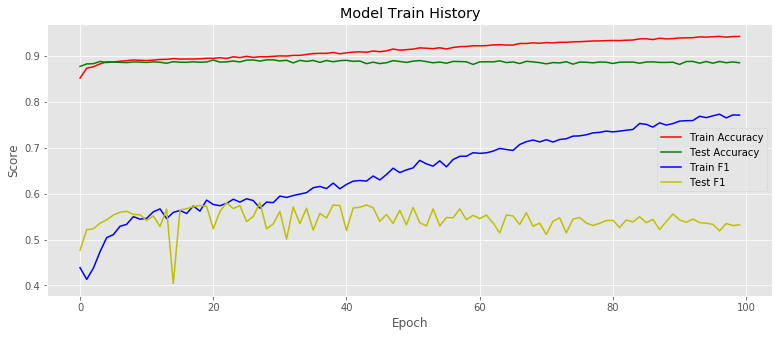

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Electronics,53.40,52.96,68.75,59.83,52.18,0.47,0.53,1981,2019
1,Refrigerator,62.55,55.52,51.80,53.59,61.10,0.37,0.61,2330,1670
2,Dishwasher,98.80,0.00,0.00,0.00,49.70,0.01,0.50,3967,33
3,Furnace,98.32,10.71,26.09,15.19,57.17,0.02,0.62,3977,23
4,Washer Dryer 1,98.78,67.03,76.25,71.35,85.36,0.01,0.88,3920,80
5,Washer Dryer 2,97.40,62.63,48.06,54.39,76.52,0.03,0.74,3871,129
6,Microwave,99.52,0.00,0.00,0.00,49.88,0.00,0.50,3981,19
7,Bathroom GFI,99.02,0.00,0.00,0.00,49.76,0.01,0.50,3961,39
8,Kitchen Outlets,89.12,47.62,2.30,4.40,49.32,0.11,0.51,3566,434



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,88.55,32.94,30.36,28.75,59.00,0.11,0.60,3506.0,494.0
max,99.52,67.03,76.25,71.35,85.36,0.47,0.88,3981.0,2019.0
min,53.40,0.00,0.00,0.00,49.32,0.00,0.50,1981.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Electronics:
[[ 748 1233]
 [ 631 1388]]

 - Refrigerator:
[[1637  693]
 [ 805  865]]

 - Dishwasher:
[[3952   15]
 [  33    0]]

 - Furnace:
[[3927   50]
 [  17    6]]

 - Washer Dryer 1:
[[3890   30]
 [  19   61]]

 - Washer Dryer 2:
[[3834   37]
 [  67   62]]

 - Microwave:
[[3981    0]
 [  19    0]]

 - Bathroom GFI:
[[3961    0]
 [  39    0]]

 - Kitchen Outlets:
[[3555   11]
 [ 424   10]]


In [19]:
# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(model_h3.predict(Xh3_test).round())
classification_report(y_test, y_pred, labels = appliance_labels)

## Gráfico de Recorrência (RP)

Loading RP images (train)...


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 483.47it/s]


(4000, 128, 128, 3)
[1 0 0 0 0 0 0 0 0]


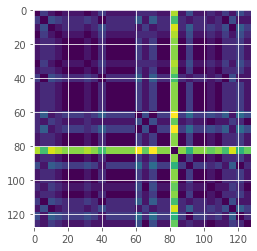

In [20]:
print("Loading RP images (train)...")
rp_images = []
yh4_train = []
for path in tqdm(glob( os.path.join(HYPOTHESIS_RESOURCES_PATH, "*train_color.png") )):    
    # RP...
    img = keras_image.load_img( path, target_size=(128, 128 ,3))
    img = keras_image.img_to_array(img)
    img = img/255
    rp_images.append(img)
    # Labels...
    image_labels = [int(l) for l in list(path.split("\\")[-1].split(".")[0].split("_")[1])]
    yh4_train.append(image_labels)
    
Xh4_train = np.array(rp_images)
yh4_train = np.array(yh4_train)

print(Xh4_train.shape)
plt.imshow(Xh4_train[88])

print(yh4_train[88])

Loading RP images (test)...


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:09<00:00, 415.56it/s]


(4000, 128, 128, 3)
[0 0 0 0 0 0 0 0 0]


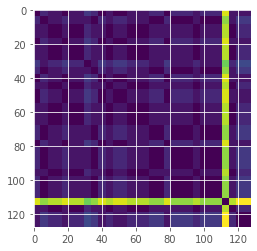

In [21]:
print("Loading RP images (test)...")
rp_images = []
yh4_test = []
for path in tqdm(glob( os.path.join(HYPOTHESIS_RESOURCES_PATH, "*test_color.png") )):    
    # RP...
    img = keras_image.load_img( path, target_size=(128, 128 ,3))
    img = keras_image.img_to_array(img)
    img = img/255
    rp_images.append(img)
    # Labels...
    image_labels = [int(l) for l in list(path.split("\\")[-1].split(".")[0].split("_")[1])]
    yh4_test.append(image_labels)
    
Xh4_test = np.array(rp_images)
yh4_test = np.array(yh4_test)

print(Xh4_test.shape)
plt.imshow(Xh4_test[88])

print(yh4_test[88])

In [22]:
model_h4 = Sequential()

model_h4.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(128,128,3)))
model_h4.add(MaxPooling2D(pool_size=(2, 2)))
model_h4.add(Dropout(0.25))
model_h4.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model_h4.add(MaxPooling2D(pool_size=(2, 2)))
model_h4.add(Dropout(0.25))
model_h4.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model_h4.add(MaxPooling2D(pool_size=(2, 2)))
model_h4.add(Dropout(0.25))
model_h4.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model_h4.add(MaxPooling2D(pool_size=(2, 2)))
model_h4.add(Dropout(0.25))
model_h4.add(Flatten())
model_h4.add(Dense(128, activation='relu'))
model_h4.add(Dropout(0.5))
model_h4.add(Dense(64, activation='relu'))
model_h4.add(Dropout(0.5))

model_h4.add(Dense(9, activation='sigmoid'))

model_h4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m])

model_h4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 124, 124, 16)      1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 58, 58, 32)        12832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 64)       

In [23]:
# Model fit...
print("Training the model...")
callback = model_h4.fit(
    Xh4_train, yh4_train,
    validation_data=(Xh4_test, yh4_test), 
    epochs=100, batch_size=32,
    verbose = 1#, callbacks = [tqdm_callback]
)

Training the model...
Train on 4000 samples, validate on 4000 samples
Epoch 1/100
4000/4000 [==============================] - ETA: 49s - loss: 0.6953 - acc: 0.5278 - f1_m: 0.227 - ETA: 19s - loss: 0.6119 - acc: 0.6609 - f1_m: 0.243 - ETA: 13s - loss: 0.5536 - acc: 0.7153 - f1_m: 0.275 - ETA: 10s - loss: 0.5206 - acc: 0.7386 - f1_m: 0.281 - ETA: 9s - loss: 0.5009 - acc: 0.7519 - f1_m: 0.273 - ETA: 8s - loss: 0.4819 - acc: 0.7658 - f1_m: 0.28 - ETA: 7s - loss: 0.4641 - acc: 0.7762 - f1_m: 0.30 - ETA: 6s - loss: 0.4532 - acc: 0.7836 - f1_m: 0.30 - ETA: 6s - loss: 0.4482 - acc: 0.7908 - f1_m: 0.31 - ETA: 5s - loss: 0.4422 - acc: 0.7961 - f1_m: 0.32 - ETA: 5s - loss: 0.4360 - acc: 0.8003 - f1_m: 0.32 - ETA: 5s - loss: 0.4263 - acc: 0.8074 - f1_m: 0.34 - ETA: 5s - loss: 0.4211 - acc: 0.8111 - f1_m: 0.35 - ETA: 4s - loss: 0.4143 - acc: 0.8155 - f1_m: 0.36 - ETA: 4s - loss: 0.4080 - acc: 0.8193 - f1_m: 0.37 - ETA: 4s - loss: 0.4002 - acc: 0.8244 - f1_m: 0.38 - ETA: 4s - loss: 0.3939 - acc: 0.

4000/4000 [==============================] - ETA: 4s - loss: 0.2663 - acc: 0.8854 - f1_m: 0.54 - ETA: 4s - loss: 0.2434 - acc: 0.8854 - f1_m: 0.51 - ETA: 4s - loss: 0.2619 - acc: 0.8799 - f1_m: 0.49 - ETA: 4s - loss: 0.2465 - acc: 0.8874 - f1_m: 0.51 - ETA: 4s - loss: 0.2458 - acc: 0.8885 - f1_m: 0.50 - ETA: 4s - loss: 0.2557 - acc: 0.8848 - f1_m: 0.50 - ETA: 3s - loss: 0.2554 - acc: 0.8809 - f1_m: 0.50 - ETA: 3s - loss: 0.2535 - acc: 0.8808 - f1_m: 0.50 - ETA: 3s - loss: 0.2505 - acc: 0.8830 - f1_m: 0.50 - ETA: 3s - loss: 0.2515 - acc: 0.8841 - f1_m: 0.50 - ETA: 3s - loss: 0.2530 - acc: 0.8844 - f1_m: 0.51 - ETA: 3s - loss: 0.2512 - acc: 0.8842 - f1_m: 0.50 - ETA: 3s - loss: 0.2491 - acc: 0.8857 - f1_m: 0.50 - ETA: 3s - loss: 0.2503 - acc: 0.8846 - f1_m: 0.49 - ETA: 3s - loss: 0.2534 - acc: 0.8836 - f1_m: 0.49 - ETA: 3s - loss: 0.2533 - acc: 0.8835 - f1_m: 0.49 - ETA: 3s - loss: 0.2536 - acc: 0.8838 - f1_m: 0.49 - ETA: 3s - loss: 0.2550 - acc: 0.8831 - f1_m: 0.48 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2213 - acc: 0.8854 - f1_m: 0.29 - ETA: 4s - loss: 0.2416 - acc: 0.8924 - f1_m: 0.46 - ETA: 4s - loss: 0.2310 - acc: 0.8875 - f1_m: 0.45 - ETA: 4s - loss: 0.2420 - acc: 0.8859 - f1_m: 0.46 - ETA: 4s - loss: 0.2433 - acc: 0.8889 - f1_m: 0.48 - ETA: 4s - loss: 0.2444 - acc: 0.8879 - f1_m: 0.48 - ETA: 4s - loss: 0.2427 - acc: 0.8889 - f1_m: 0.48 - ETA: 3s - loss: 0.2373 - acc: 0.8907 - f1_m: 0.48 - ETA: 3s - loss: 0.2360 - acc: 0.8913 - f1_m: 0.49 - ETA: 3s - loss: 0.2390 - acc: 0.8900 - f1_m: 0.49 - ETA: 3s - loss: 0.2412 - acc: 0.8897 - f1_m: 0.49 - ETA: 3s - loss: 0.2410 - acc: 0.8899 - f1_m: 0.50 - ETA: 3s - loss: 0.2409 - acc: 0.8886 - f1_m: 0.49 - ETA: 3s - loss: 0.2407 - acc: 0.8895 - f1_m: 0.49 - ETA: 3s - loss: 0.2379 - acc: 0.8916 - f1_m: 0.49 - ETA: 3s - loss: 0.2371 - acc: 0.8910 - f1_m: 0.48 - ETA: 3s - loss: 0.2415 - acc: 0.8891 - f1_m: 0.48 - ETA: 3s - loss: 0.2424 - acc: 0.8887 - f1_m: 0.48 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2158 - acc: 0.8785 - f1_m: 0.49 - ETA: 4s - loss: 0.2227 - acc: 0.8831 - f1_m: 0.50 - ETA: 4s - loss: 0.2425 - acc: 0.8847 - f1_m: 0.51 - ETA: 4s - loss: 0.2430 - acc: 0.8859 - f1_m: 0.52 - ETA: 4s - loss: 0.2399 - acc: 0.8881 - f1_m: 0.53 - ETA: 4s - loss: 0.2424 - acc: 0.8873 - f1_m: 0.53 - ETA: 4s - loss: 0.2376 - acc: 0.8897 - f1_m: 0.53 - ETA: 3s - loss: 0.2364 - acc: 0.8921 - f1_m: 0.54 - ETA: 3s - loss: 0.2342 - acc: 0.8922 - f1_m: 0.54 - ETA: 3s - loss: 0.2319 - acc: 0.8922 - f1_m: 0.54 - ETA: 3s - loss: 0.2361 - acc: 0.8907 - f1_m: 0.54 - ETA: 3s - loss: 0.2334 - acc: 0.8916 - f1_m: 0.54 - ETA: 3s - loss: 0.2326 - acc: 0.8908 - f1_m: 0.54 - ETA: 3s - loss: 0.2340 - acc: 0.8903 - f1_m: 0.53 - ETA: 3s - loss: 0.2379 - acc: 0.8879 - f1_m: 0.53 - ETA: 3s - loss: 0.2402 - acc: 0.8877 - f1_m: 0.53 - ETA: 3s - loss: 0.2381 - acc: 0.8890 - f1_m: 0.53 - ETA: 3s - loss: 0.2377 - acc: 0.8893 - f1_m: 0.53 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2371 - acc: 0.8993 - f1_m: 0.62 - ETA: 4s - loss: 0.2437 - acc: 0.8854 - f1_m: 0.56 - ETA: 4s - loss: 0.2375 - acc: 0.8917 - f1_m: 0.57 - ETA: 4s - loss: 0.2301 - acc: 0.8899 - f1_m: 0.56 - ETA: 4s - loss: 0.2325 - acc: 0.8927 - f1_m: 0.57 - ETA: 4s - loss: 0.2248 - acc: 0.8949 - f1_m: 0.57 - ETA: 3s - loss: 0.2288 - acc: 0.8900 - f1_m: 0.55 - ETA: 3s - loss: 0.2278 - acc: 0.8903 - f1_m: 0.55 - ETA: 3s - loss: 0.2301 - acc: 0.8903 - f1_m: 0.55 - ETA: 3s - loss: 0.2333 - acc: 0.8904 - f1_m: 0.56 - ETA: 3s - loss: 0.2294 - acc: 0.8924 - f1_m: 0.57 - ETA: 3s - loss: 0.2297 - acc: 0.8928 - f1_m: 0.57 - ETA: 3s - loss: 0.2322 - acc: 0.8915 - f1_m: 0.57 - ETA: 3s - loss: 0.2308 - acc: 0.8912 - f1_m: 0.56 - ETA: 3s - loss: 0.2297 - acc: 0.8921 - f1_m: 0.56 - ETA: 3s - loss: 0.2306 - acc: 0.8918 - f1_m: 0.56 - ETA: 3s - loss: 0.2325 - acc: 0.8915 - f1_m: 0.56 - ETA: 3s - loss: 0.2323 - acc: 0.8918 - f1_m: 0.56 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2494 - acc: 0.8611 - f1_m: 0.50 - ETA: 4s - loss: 0.2170 - acc: 0.8889 - f1_m: 0.57 - ETA: 4s - loss: 0.2436 - acc: 0.8840 - f1_m: 0.57 - ETA: 4s - loss: 0.2492 - acc: 0.8814 - f1_m: 0.56 - ETA: 4s - loss: 0.2414 - acc: 0.8866 - f1_m: 0.57 - ETA: 4s - loss: 0.2397 - acc: 0.8864 - f1_m: 0.57 - ETA: 4s - loss: 0.2334 - acc: 0.8889 - f1_m: 0.57 - ETA: 3s - loss: 0.2300 - acc: 0.8884 - f1_m: 0.57 - ETA: 3s - loss: 0.2258 - acc: 0.8913 - f1_m: 0.57 - ETA: 3s - loss: 0.2343 - acc: 0.8883 - f1_m: 0.56 - ETA: 3s - loss: 0.2313 - acc: 0.8886 - f1_m: 0.55 - ETA: 3s - loss: 0.2277 - acc: 0.8913 - f1_m: 0.56 - ETA: 3s - loss: 0.2263 - acc: 0.8931 - f1_m: 0.57 - ETA: 3s - loss: 0.2249 - acc: 0.8936 - f1_m: 0.57 - ETA: 3s - loss: 0.2244 - acc: 0.8946 - f1_m: 0.57 - ETA: 3s - loss: 0.2251 - acc: 0.8935 - f1_m: 0.56 - ETA: 3s - loss: 0.2288 - acc: 0.8933 - f1_m: 0.56 - ETA: 3s - loss: 0.2286 - acc: 0.8931 - f1_m: 0.56 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2540 - acc: 0.8993 - f1_m: 0.66 - ETA: 4s - loss: 0.2302 - acc: 0.8970 - f1_m: 0.59 - ETA: 4s - loss: 0.2494 - acc: 0.8903 - f1_m: 0.59 - ETA: 4s - loss: 0.2401 - acc: 0.8919 - f1_m: 0.56 - ETA: 4s - loss: 0.2448 - acc: 0.8877 - f1_m: 0.54 - ETA: 4s - loss: 0.2421 - acc: 0.8892 - f1_m: 0.54 - ETA: 4s - loss: 0.2385 - acc: 0.8921 - f1_m: 0.56 - ETA: 3s - loss: 0.2361 - acc: 0.8935 - f1_m: 0.56 - ETA: 3s - loss: 0.2414 - acc: 0.8936 - f1_m: 0.56 - ETA: 3s - loss: 0.2443 - acc: 0.8913 - f1_m: 0.56 - ETA: 3s - loss: 0.2428 - acc: 0.8915 - f1_m: 0.56 - ETA: 3s - loss: 0.2394 - acc: 0.8918 - f1_m: 0.55 - ETA: 3s - loss: 0.2372 - acc: 0.8925 - f1_m: 0.54 - ETA: 3s - loss: 0.2346 - acc: 0.8933 - f1_m: 0.54 - ETA: 3s - loss: 0.2349 - acc: 0.8940 - f1_m: 0.54 - ETA: 3s - loss: 0.2320 - acc: 0.8950 - f1_m: 0.54 - ETA: 3s - loss: 0.2329 - acc: 0.8946 - f1_m: 0.54 - ETA: 3s - loss: 0.2325 - acc: 0.8944 - f1_m: 0.54 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.1956 - acc: 0.9028 - f1_m: 0.54 - ETA: 4s - loss: 0.2079 - acc: 0.8924 - f1_m: 0.46 - ETA: 4s - loss: 0.2183 - acc: 0.8903 - f1_m: 0.50 - ETA: 4s - loss: 0.2124 - acc: 0.8988 - f1_m: 0.54 - ETA: 4s - loss: 0.2169 - acc: 0.8985 - f1_m: 0.55 - ETA: 4s - loss: 0.2201 - acc: 0.8971 - f1_m: 0.56 - ETA: 4s - loss: 0.2198 - acc: 0.8985 - f1_m: 0.57 - ETA: 3s - loss: 0.2154 - acc: 0.9005 - f1_m: 0.57 - ETA: 3s - loss: 0.2146 - acc: 0.9003 - f1_m: 0.57 - ETA: 3s - loss: 0.2111 - acc: 0.9019 - f1_m: 0.58 - ETA: 3s - loss: 0.2116 - acc: 0.9018 - f1_m: 0.56 - ETA: 3s - loss: 0.2136 - acc: 0.9010 - f1_m: 0.56 - ETA: 3s - loss: 0.2154 - acc: 0.8997 - f1_m: 0.56 - ETA: 3s - loss: 0.2137 - acc: 0.9010 - f1_m: 0.56 - ETA: 3s - loss: 0.2134 - acc: 0.9011 - f1_m: 0.56 - ETA: 3s - loss: 0.2117 - acc: 0.9019 - f1_m: 0.56 - ETA: 3s - loss: 0.2131 - acc: 0.9010 - f1_m: 0.56 - ETA: 3s - loss: 0.2154 - acc: 0.9001 - f1_m: 0.56 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2083 - acc: 0.8854 - f1_m: 0.44 - ETA: 4s - loss: 0.2023 - acc: 0.8970 - f1_m: 0.55 - ETA: 4s - loss: 0.2005 - acc: 0.9021 - f1_m: 0.57 - ETA: 4s - loss: 0.2054 - acc: 0.9043 - f1_m: 0.58 - ETA: 4s - loss: 0.2087 - acc: 0.9005 - f1_m: 0.56 - ETA: 4s - loss: 0.2115 - acc: 0.9009 - f1_m: 0.56 - ETA: 4s - loss: 0.2126 - acc: 0.9001 - f1_m: 0.56 - ETA: 3s - loss: 0.2143 - acc: 0.9007 - f1_m: 0.57 - ETA: 3s - loss: 0.2116 - acc: 0.9022 - f1_m: 0.57 - ETA: 3s - loss: 0.2116 - acc: 0.9031 - f1_m: 0.58 - ETA: 3s - loss: 0.2155 - acc: 0.9018 - f1_m: 0.57 - ETA: 3s - loss: 0.2165 - acc: 0.9011 - f1_m: 0.57 - ETA: 3s - loss: 0.2155 - acc: 0.9015 - f1_m: 0.58 - ETA: 3s - loss: 0.2152 - acc: 0.9015 - f1_m: 0.58 - ETA: 3s - loss: 0.2144 - acc: 0.9012 - f1_m: 0.58 - ETA: 3s - loss: 0.2152 - acc: 0.9019 - f1_m: 0.58 - ETA: 3s - loss: 0.2169 - acc: 0.9014 - f1_m: 0.58 - ETA: 3s - loss: 0.2178 - acc: 0.9006 - f1_m: 0.58 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2568 - acc: 0.8889 - f1_m: 0.55 - ETA: 4s - loss: 0.2229 - acc: 0.9028 - f1_m: 0.58 - ETA: 4s - loss: 0.2069 - acc: 0.9139 - f1_m: 0.63 - ETA: 4s - loss: 0.2029 - acc: 0.9162 - f1_m: 0.64 - ETA: 4s - loss: 0.2036 - acc: 0.9136 - f1_m: 0.62 - ETA: 4s - loss: 0.2082 - acc: 0.9110 - f1_m: 0.59 - ETA: 3s - loss: 0.2082 - acc: 0.9113 - f1_m: 0.59 - ETA: 3s - loss: 0.2142 - acc: 0.9086 - f1_m: 0.59 - ETA: 3s - loss: 0.2103 - acc: 0.9091 - f1_m: 0.59 - ETA: 3s - loss: 0.2120 - acc: 0.9075 - f1_m: 0.59 - ETA: 3s - loss: 0.2140 - acc: 0.9061 - f1_m: 0.60 - ETA: 3s - loss: 0.2165 - acc: 0.9046 - f1_m: 0.60 - ETA: 3s - loss: 0.2175 - acc: 0.9029 - f1_m: 0.60 - ETA: 3s - loss: 0.2182 - acc: 0.9025 - f1_m: 0.59 - ETA: 3s - loss: 0.2160 - acc: 0.9039 - f1_m: 0.59 - ETA: 3s - loss: 0.2142 - acc: 0.9043 - f1_m: 0.59 - ETA: 3s - loss: 0.2132 - acc: 0.9046 - f1_m: 0.59 - ETA: 3s - loss: 0.2108 - acc: 0.9056 - f1_m: 0.59 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2026 - acc: 0.9132 - f1_m: 0.59 - ETA: 4s - loss: 0.2042 - acc: 0.9086 - f1_m: 0.60 - ETA: 4s - loss: 0.2096 - acc: 0.9035 - f1_m: 0.56 - ETA: 4s - loss: 0.2106 - acc: 0.9018 - f1_m: 0.54 - ETA: 4s - loss: 0.2222 - acc: 0.9001 - f1_m: 0.52 - ETA: 4s - loss: 0.2200 - acc: 0.9003 - f1_m: 0.52 - ETA: 4s - loss: 0.2177 - acc: 0.9028 - f1_m: 0.54 - ETA: 3s - loss: 0.2169 - acc: 0.9032 - f1_m: 0.55 - ETA: 3s - loss: 0.2179 - acc: 0.9016 - f1_m: 0.55 - ETA: 3s - loss: 0.2180 - acc: 0.8999 - f1_m: 0.54 - ETA: 3s - loss: 0.2183 - acc: 0.8995 - f1_m: 0.54 - ETA: 3s - loss: 0.2146 - acc: 0.9008 - f1_m: 0.55 - ETA: 3s - loss: 0.2144 - acc: 0.9012 - f1_m: 0.55 - ETA: 3s - loss: 0.2140 - acc: 0.9015 - f1_m: 0.56 - ETA: 3s - loss: 0.2134 - acc: 0.9011 - f1_m: 0.56 - ETA: 3s - loss: 0.2124 - acc: 0.9020 - f1_m: 0.56 - ETA: 3s - loss: 0.2127 - acc: 0.9026 - f1_m: 0.56 - ETA: 3s - loss: 0.2114 - acc: 0.9033 - f1_m: 0.56 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2015 - acc: 0.9062 - f1_m: 0.57 - ETA: 4s - loss: 0.2104 - acc: 0.9016 - f1_m: 0.56 - ETA: 4s - loss: 0.1970 - acc: 0.9000 - f1_m: 0.58 - ETA: 4s - loss: 0.1992 - acc: 0.9023 - f1_m: 0.57 - ETA: 4s - loss: 0.2060 - acc: 0.9035 - f1_m: 0.59 - ETA: 4s - loss: 0.2125 - acc: 0.9031 - f1_m: 0.60 - ETA: 4s - loss: 0.2142 - acc: 0.9038 - f1_m: 0.60 - ETA: 3s - loss: 0.2144 - acc: 0.9037 - f1_m: 0.60 - ETA: 3s - loss: 0.2121 - acc: 0.9034 - f1_m: 0.58 - ETA: 3s - loss: 0.2118 - acc: 0.9039 - f1_m: 0.57 - ETA: 3s - loss: 0.2136 - acc: 0.9038 - f1_m: 0.57 - ETA: 3s - loss: 0.2122 - acc: 0.9047 - f1_m: 0.57 - ETA: 3s - loss: 0.2129 - acc: 0.9038 - f1_m: 0.57 - ETA: 3s - loss: 0.2102 - acc: 0.9055 - f1_m: 0.58 - ETA: 3s - loss: 0.2088 - acc: 0.9062 - f1_m: 0.58 - ETA: 3s - loss: 0.2075 - acc: 0.9060 - f1_m: 0.58 - ETA: 3s - loss: 0.2058 - acc: 0.9066 - f1_m: 0.58 - ETA: 3s - loss: 0.2068 - acc: 0.9055 - f1_m: 0.58 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.1883 - acc: 0.9167 - f1_m: 0.47 - ETA: 4s - loss: 0.1955 - acc: 0.9155 - f1_m: 0.54 - ETA: 4s - loss: 0.1972 - acc: 0.9076 - f1_m: 0.54 - ETA: 4s - loss: 0.1988 - acc: 0.9072 - f1_m: 0.55 - ETA: 4s - loss: 0.1948 - acc: 0.9117 - f1_m: 0.59 - ETA: 4s - loss: 0.1946 - acc: 0.9104 - f1_m: 0.60 - ETA: 4s - loss: 0.1931 - acc: 0.9132 - f1_m: 0.61 - ETA: 3s - loss: 0.1931 - acc: 0.9134 - f1_m: 0.61 - ETA: 3s - loss: 0.1915 - acc: 0.9150 - f1_m: 0.62 - ETA: 3s - loss: 0.1918 - acc: 0.9143 - f1_m: 0.61 - ETA: 3s - loss: 0.1950 - acc: 0.9117 - f1_m: 0.60 - ETA: 3s - loss: 0.1976 - acc: 0.9114 - f1_m: 0.61 - ETA: 3s - loss: 0.1987 - acc: 0.9111 - f1_m: 0.61 - ETA: 3s - loss: 0.2001 - acc: 0.9099 - f1_m: 0.61 - ETA: 3s - loss: 0.2004 - acc: 0.9094 - f1_m: 0.61 - ETA: 3s - loss: 0.2005 - acc: 0.9087 - f1_m: 0.60 - ETA: 3s - loss: 0.1984 - acc: 0.9093 - f1_m: 0.60 - ETA: 3s - loss: 0.1996 - acc: 0.9083 - f1_m: 0.59 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1693 - acc: 0.9167 - f1_m: 0.58 - ETA: 4s - loss: 0.1693 - acc: 0.9213 - f1_m: 0.59 - ETA: 4s - loss: 0.1883 - acc: 0.9083 - f1_m: 0.56 - ETA: 4s - loss: 0.2006 - acc: 0.9043 - f1_m: 0.56 - ETA: 4s - loss: 0.1932 - acc: 0.9097 - f1_m: 0.57 - ETA: 4s - loss: 0.1973 - acc: 0.9081 - f1_m: 0.57 - ETA: 3s - loss: 0.1979 - acc: 0.9073 - f1_m: 0.56 - ETA: 3s - loss: 0.2007 - acc: 0.9069 - f1_m: 0.57 - ETA: 3s - loss: 0.2025 - acc: 0.9067 - f1_m: 0.56 - ETA: 3s - loss: 0.2058 - acc: 0.9055 - f1_m: 0.57 - ETA: 3s - loss: 0.2068 - acc: 0.9051 - f1_m: 0.57 - ETA: 3s - loss: 0.2052 - acc: 0.9052 - f1_m: 0.56 - ETA: 3s - loss: 0.2061 - acc: 0.9050 - f1_m: 0.56 - ETA: 3s - loss: 0.2073 - acc: 0.9051 - f1_m: 0.56 - ETA: 3s - loss: 0.2058 - acc: 0.9057 - f1_m: 0.56 - ETA: 3s - loss: 0.2061 - acc: 0.9047 - f1_m: 0.56 - ETA: 3s - loss: 0.2060 - acc: 0.9057 - f1_m: 0.57 - ETA: 3s - loss: 0.2058 - acc: 0.9058 - f1_m: 0.57 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2191 - acc: 0.8819 - f1_m: 0.56 - ETA: 4s - loss: 0.2195 - acc: 0.8900 - f1_m: 0.57 - ETA: 4s - loss: 0.2216 - acc: 0.8882 - f1_m: 0.53 - ETA: 4s - loss: 0.2148 - acc: 0.8973 - f1_m: 0.57 - ETA: 4s - loss: 0.2134 - acc: 0.8981 - f1_m: 0.58 - ETA: 3s - loss: 0.2102 - acc: 0.9003 - f1_m: 0.58 - ETA: 3s - loss: 0.2107 - acc: 0.9014 - f1_m: 0.59 - ETA: 3s - loss: 0.2130 - acc: 0.9021 - f1_m: 0.60 - ETA: 3s - loss: 0.2105 - acc: 0.9022 - f1_m: 0.59 - ETA: 3s - loss: 0.2089 - acc: 0.9030 - f1_m: 0.60 - ETA: 3s - loss: 0.2120 - acc: 0.9008 - f1_m: 0.59 - ETA: 3s - loss: 0.2148 - acc: 0.8995 - f1_m: 0.59 - ETA: 3s - loss: 0.2140 - acc: 0.8994 - f1_m: 0.59 - ETA: 3s - loss: 0.2152 - acc: 0.8984 - f1_m: 0.59 - ETA: 3s - loss: 0.2145 - acc: 0.8981 - f1_m: 0.58 - ETA: 3s - loss: 0.2130 - acc: 0.8995 - f1_m: 0.59 - ETA: 3s - loss: 0.2132 - acc: 0.8996 - f1_m: 0.59 - ETA: 3s - loss: 0.2112 - acc: 0.9001 - f1_m: 0.58 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.1991 - acc: 0.9132 - f1_m: 0.61 - ETA: 4s - loss: 0.2120 - acc: 0.9005 - f1_m: 0.60 - ETA: 4s - loss: 0.1927 - acc: 0.9069 - f1_m: 0.60 - ETA: 4s - loss: 0.2041 - acc: 0.9028 - f1_m: 0.59 - ETA: 4s - loss: 0.1968 - acc: 0.9097 - f1_m: 0.61 - ETA: 4s - loss: 0.1949 - acc: 0.9085 - f1_m: 0.60 - ETA: 4s - loss: 0.1946 - acc: 0.9068 - f1_m: 0.59 - ETA: 3s - loss: 0.1926 - acc: 0.9072 - f1_m: 0.59 - ETA: 3s - loss: 0.1908 - acc: 0.9095 - f1_m: 0.60 - ETA: 3s - loss: 0.1938 - acc: 0.9079 - f1_m: 0.60 - ETA: 3s - loss: 0.1924 - acc: 0.9091 - f1_m: 0.60 - ETA: 3s - loss: 0.1939 - acc: 0.9085 - f1_m: 0.60 - ETA: 3s - loss: 0.1952 - acc: 0.9082 - f1_m: 0.61 - ETA: 3s - loss: 0.1972 - acc: 0.9074 - f1_m: 0.61 - ETA: 3s - loss: 0.1966 - acc: 0.9080 - f1_m: 0.60 - ETA: 3s - loss: 0.1965 - acc: 0.9088 - f1_m: 0.60 - ETA: 3s - loss: 0.1975 - acc: 0.9082 - f1_m: 0.60 - ETA: 3s - loss: 0.1979 - acc: 0.9082 - f1_m: 0.59 - ETA: 3s - loss: 0.2

4000/4000 [==============================] - ETA: 4s - loss: 0.2068 - acc: 0.9132 - f1_m: 0.62 - ETA: 4s - loss: 0.1919 - acc: 0.9144 - f1_m: 0.61 - ETA: 4s - loss: 0.2013 - acc: 0.9089 - f1_m: 0.60 - ETA: 4s - loss: 0.1994 - acc: 0.9155 - f1_m: 0.64 - ETA: 4s - loss: 0.1982 - acc: 0.9128 - f1_m: 0.62 - ETA: 4s - loss: 0.1991 - acc: 0.9115 - f1_m: 0.62 - ETA: 4s - loss: 0.1985 - acc: 0.9115 - f1_m: 0.62 - ETA: 4s - loss: 0.1967 - acc: 0.9100 - f1_m: 0.61 - ETA: 4s - loss: 0.1956 - acc: 0.9125 - f1_m: 0.62 - ETA: 3s - loss: 0.1938 - acc: 0.9132 - f1_m: 0.62 - ETA: 3s - loss: 0.1933 - acc: 0.9134 - f1_m: 0.62 - ETA: 3s - loss: 0.1928 - acc: 0.9127 - f1_m: 0.61 - ETA: 3s - loss: 0.1930 - acc: 0.9116 - f1_m: 0.61 - ETA: 3s - loss: 0.1927 - acc: 0.9115 - f1_m: 0.61 - ETA: 3s - loss: 0.1915 - acc: 0.9123 - f1_m: 0.61 - ETA: 3s - loss: 0.1944 - acc: 0.9115 - f1_m: 0.61 - ETA: 3s - loss: 0.1964 - acc: 0.9100 - f1_m: 0.60 - ETA: 3s - loss: 0.1968 - acc: 0.9100 - f1_m: 0.60 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1511 - acc: 0.9306 - f1_m: 0.54 - ETA: 4s - loss: 0.2228 - acc: 0.9074 - f1_m: 0.55 - ETA: 4s - loss: 0.2217 - acc: 0.9056 - f1_m: 0.56 - ETA: 4s - loss: 0.2097 - acc: 0.9092 - f1_m: 0.58 - ETA: 4s - loss: 0.2076 - acc: 0.9062 - f1_m: 0.58 - ETA: 4s - loss: 0.2062 - acc: 0.9072 - f1_m: 0.59 - ETA: 4s - loss: 0.2065 - acc: 0.9060 - f1_m: 0.58 - ETA: 3s - loss: 0.2079 - acc: 0.9051 - f1_m: 0.57 - ETA: 3s - loss: 0.2021 - acc: 0.9071 - f1_m: 0.58 - ETA: 3s - loss: 0.2022 - acc: 0.9072 - f1_m: 0.58 - ETA: 3s - loss: 0.2017 - acc: 0.9072 - f1_m: 0.58 - ETA: 3s - loss: 0.1994 - acc: 0.9073 - f1_m: 0.58 - ETA: 3s - loss: 0.1990 - acc: 0.9089 - f1_m: 0.59 - ETA: 3s - loss: 0.1978 - acc: 0.9100 - f1_m: 0.60 - ETA: 3s - loss: 0.1971 - acc: 0.9104 - f1_m: 0.59 - ETA: 3s - loss: 0.1953 - acc: 0.9113 - f1_m: 0.59 - ETA: 3s - loss: 0.1966 - acc: 0.9114 - f1_m: 0.59 - ETA: 3s - loss: 0.1964 - acc: 0.9111 - f1_m: 0.59 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1888 - acc: 0.9097 - f1_m: 0.71 - ETA: 4s - loss: 0.2066 - acc: 0.8981 - f1_m: 0.66 - ETA: 4s - loss: 0.1964 - acc: 0.9007 - f1_m: 0.63 - ETA: 4s - loss: 0.1919 - acc: 0.9018 - f1_m: 0.63 - ETA: 4s - loss: 0.1894 - acc: 0.9028 - f1_m: 0.63 - ETA: 4s - loss: 0.1942 - acc: 0.9047 - f1_m: 0.62 - ETA: 4s - loss: 0.1926 - acc: 0.9076 - f1_m: 0.62 - ETA: 3s - loss: 0.1957 - acc: 0.9076 - f1_m: 0.62 - ETA: 3s - loss: 0.1967 - acc: 0.9062 - f1_m: 0.61 - ETA: 3s - loss: 0.1955 - acc: 0.9070 - f1_m: 0.62 - ETA: 3s - loss: 0.1964 - acc: 0.9074 - f1_m: 0.61 - ETA: 3s - loss: 0.1950 - acc: 0.9087 - f1_m: 0.61 - ETA: 3s - loss: 0.1935 - acc: 0.9090 - f1_m: 0.60 - ETA: 3s - loss: 0.1929 - acc: 0.9096 - f1_m: 0.61 - ETA: 3s - loss: 0.1915 - acc: 0.9098 - f1_m: 0.61 - ETA: 3s - loss: 0.1921 - acc: 0.9091 - f1_m: 0.60 - ETA: 3s - loss: 0.1910 - acc: 0.9099 - f1_m: 0.61 - ETA: 3s - loss: 0.1922 - acc: 0.9093 - f1_m: 0.60 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1723 - acc: 0.9167 - f1_m: 0.63 - ETA: 4s - loss: 0.1964 - acc: 0.9028 - f1_m: 0.56 - ETA: 4s - loss: 0.1933 - acc: 0.9056 - f1_m: 0.58 - ETA: 4s - loss: 0.1854 - acc: 0.9063 - f1_m: 0.57 - ETA: 4s - loss: 0.1838 - acc: 0.9093 - f1_m: 0.59 - ETA: 4s - loss: 0.1832 - acc: 0.9100 - f1_m: 0.59 - ETA: 4s - loss: 0.1876 - acc: 0.9089 - f1_m: 0.58 - ETA: 3s - loss: 0.1891 - acc: 0.9102 - f1_m: 0.58 - ETA: 3s - loss: 0.1884 - acc: 0.9109 - f1_m: 0.59 - ETA: 3s - loss: 0.1879 - acc: 0.9110 - f1_m: 0.59 - ETA: 3s - loss: 0.1880 - acc: 0.9104 - f1_m: 0.58 - ETA: 3s - loss: 0.1885 - acc: 0.9097 - f1_m: 0.58 - ETA: 3s - loss: 0.1869 - acc: 0.9103 - f1_m: 0.59 - ETA: 3s - loss: 0.1867 - acc: 0.9106 - f1_m: 0.59 - ETA: 3s - loss: 0.1890 - acc: 0.9100 - f1_m: 0.59 - ETA: 3s - loss: 0.1866 - acc: 0.9117 - f1_m: 0.59 - ETA: 3s - loss: 0.1912 - acc: 0.9099 - f1_m: 0.59 - ETA: 3s - loss: 0.1897 - acc: 0.9109 - f1_m: 0.59 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1904 - acc: 0.9201 - f1_m: 0.71 - ETA: 4s - loss: 0.1794 - acc: 0.9225 - f1_m: 0.67 - ETA: 4s - loss: 0.1910 - acc: 0.9201 - f1_m: 0.68 - ETA: 4s - loss: 0.1950 - acc: 0.9152 - f1_m: 0.64 - ETA: 4s - loss: 0.1899 - acc: 0.9178 - f1_m: 0.64 - ETA: 4s - loss: 0.1991 - acc: 0.9135 - f1_m: 0.62 - ETA: 3s - loss: 0.1965 - acc: 0.9129 - f1_m: 0.62 - ETA: 3s - loss: 0.1962 - acc: 0.9125 - f1_m: 0.62 - ETA: 3s - loss: 0.1945 - acc: 0.9128 - f1_m: 0.63 - ETA: 3s - loss: 0.1922 - acc: 0.9136 - f1_m: 0.63 - ETA: 3s - loss: 0.1931 - acc: 0.9125 - f1_m: 0.63 - ETA: 3s - loss: 0.1920 - acc: 0.9124 - f1_m: 0.63 - ETA: 3s - loss: 0.1893 - acc: 0.9137 - f1_m: 0.63 - ETA: 3s - loss: 0.1900 - acc: 0.9140 - f1_m: 0.62 - ETA: 3s - loss: 0.1886 - acc: 0.9134 - f1_m: 0.61 - ETA: 3s - loss: 0.1890 - acc: 0.9125 - f1_m: 0.61 - ETA: 3s - loss: 0.1899 - acc: 0.9119 - f1_m: 0.61 - ETA: 3s - loss: 0.1893 - acc: 0.9121 - f1_m: 0.61 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.2476 - acc: 0.8819 - f1_m: 0.58 - ETA: 4s - loss: 0.2173 - acc: 0.8981 - f1_m: 0.59 - ETA: 4s - loss: 0.1918 - acc: 0.9104 - f1_m: 0.60 - ETA: 4s - loss: 0.1884 - acc: 0.9122 - f1_m: 0.61 - ETA: 4s - loss: 0.1898 - acc: 0.9120 - f1_m: 0.61 - ETA: 4s - loss: 0.1863 - acc: 0.9138 - f1_m: 0.62 - ETA: 4s - loss: 0.1853 - acc: 0.9145 - f1_m: 0.62 - ETA: 3s - loss: 0.1837 - acc: 0.9153 - f1_m: 0.62 - ETA: 3s - loss: 0.1834 - acc: 0.9144 - f1_m: 0.62 - ETA: 3s - loss: 0.1862 - acc: 0.9134 - f1_m: 0.62 - ETA: 3s - loss: 0.1862 - acc: 0.9120 - f1_m: 0.61 - ETA: 3s - loss: 0.1881 - acc: 0.9120 - f1_m: 0.62 - ETA: 3s - loss: 0.1880 - acc: 0.9126 - f1_m: 0.62 - ETA: 3s - loss: 0.1883 - acc: 0.9126 - f1_m: 0.61 - ETA: 3s - loss: 0.1882 - acc: 0.9126 - f1_m: 0.61 - ETA: 3s - loss: 0.1863 - acc: 0.9130 - f1_m: 0.61 - ETA: 3s - loss: 0.1870 - acc: 0.9121 - f1_m: 0.61 - ETA: 3s - loss: 0.1873 - acc: 0.9126 - f1_m: 0.61 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.2058 - acc: 0.8958 - f1_m: 0.54 - ETA: 4s - loss: 0.2040 - acc: 0.9016 - f1_m: 0.56 - ETA: 4s - loss: 0.2006 - acc: 0.9069 - f1_m: 0.60 - ETA: 4s - loss: 0.1927 - acc: 0.9053 - f1_m: 0.57 - ETA: 4s - loss: 0.1863 - acc: 0.9105 - f1_m: 0.58 - ETA: 4s - loss: 0.1902 - acc: 0.9088 - f1_m: 0.59 - ETA: 3s - loss: 0.1878 - acc: 0.9119 - f1_m: 0.59 - ETA: 3s - loss: 0.1882 - acc: 0.9111 - f1_m: 0.59 - ETA: 3s - loss: 0.1861 - acc: 0.9128 - f1_m: 0.60 - ETA: 3s - loss: 0.1834 - acc: 0.9143 - f1_m: 0.60 - ETA: 3s - loss: 0.1802 - acc: 0.9163 - f1_m: 0.61 - ETA: 3s - loss: 0.1809 - acc: 0.9161 - f1_m: 0.61 - ETA: 3s - loss: 0.1822 - acc: 0.9158 - f1_m: 0.61 - ETA: 3s - loss: 0.1816 - acc: 0.9167 - f1_m: 0.62 - ETA: 3s - loss: 0.1840 - acc: 0.9150 - f1_m: 0.61 - ETA: 3s - loss: 0.1846 - acc: 0.9150 - f1_m: 0.61 - ETA: 3s - loss: 0.1865 - acc: 0.9146 - f1_m: 0.61 - ETA: 3s - loss: 0.1877 - acc: 0.9136 - f1_m: 0.61 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.2331 - acc: 0.9097 - f1_m: 0.60 - ETA: 4s - loss: 0.1904 - acc: 0.9190 - f1_m: 0.59 - ETA: 4s - loss: 0.1915 - acc: 0.9194 - f1_m: 0.61 - ETA: 4s - loss: 0.1859 - acc: 0.9182 - f1_m: 0.61 - ETA: 4s - loss: 0.1850 - acc: 0.9171 - f1_m: 0.61 - ETA: 4s - loss: 0.1838 - acc: 0.9167 - f1_m: 0.60 - ETA: 4s - loss: 0.1851 - acc: 0.9132 - f1_m: 0.59 - ETA: 3s - loss: 0.1855 - acc: 0.9132 - f1_m: 0.60 - ETA: 3s - loss: 0.1843 - acc: 0.9130 - f1_m: 0.60 - ETA: 3s - loss: 0.1842 - acc: 0.9123 - f1_m: 0.60 - ETA: 3s - loss: 0.1836 - acc: 0.9134 - f1_m: 0.60 - ETA: 3s - loss: 0.1855 - acc: 0.9127 - f1_m: 0.60 - ETA: 3s - loss: 0.1864 - acc: 0.9129 - f1_m: 0.60 - ETA: 3s - loss: 0.1872 - acc: 0.9128 - f1_m: 0.60 - ETA: 3s - loss: 0.1872 - acc: 0.9131 - f1_m: 0.60 - ETA: 3s - loss: 0.1862 - acc: 0.9125 - f1_m: 0.60 - ETA: 3s - loss: 0.1854 - acc: 0.9125 - f1_m: 0.60 - ETA: 3s - loss: 0.1860 - acc: 0.9125 - f1_m: 0.60 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1644 - acc: 0.9201 - f1_m: 0.61 - ETA: 4s - loss: 0.1763 - acc: 0.9190 - f1_m: 0.61 - ETA: 4s - loss: 0.1759 - acc: 0.9215 - f1_m: 0.63 - ETA: 4s - loss: 0.1779 - acc: 0.9187 - f1_m: 0.60 - ETA: 4s - loss: 0.1818 - acc: 0.9167 - f1_m: 0.58 - ETA: 4s - loss: 0.1840 - acc: 0.9151 - f1_m: 0.59 - ETA: 4s - loss: 0.1854 - acc: 0.9151 - f1_m: 0.60 - ETA: 3s - loss: 0.1861 - acc: 0.9148 - f1_m: 0.60 - ETA: 3s - loss: 0.1880 - acc: 0.9138 - f1_m: 0.60 - ETA: 3s - loss: 0.1880 - acc: 0.9136 - f1_m: 0.60 - ETA: 3s - loss: 0.1881 - acc: 0.9147 - f1_m: 0.61 - ETA: 3s - loss: 0.1851 - acc: 0.9153 - f1_m: 0.61 - ETA: 3s - loss: 0.1868 - acc: 0.9153 - f1_m: 0.61 - ETA: 3s - loss: 0.1872 - acc: 0.9144 - f1_m: 0.61 - ETA: 3s - loss: 0.1874 - acc: 0.9140 - f1_m: 0.61 - ETA: 3s - loss: 0.1867 - acc: 0.9139 - f1_m: 0.61 - ETA: 3s - loss: 0.1856 - acc: 0.9148 - f1_m: 0.61 - ETA: 3s - loss: 0.1856 - acc: 0.9143 - f1_m: 0.61 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1246 - acc: 0.9479 - f1_m: 0.75 - ETA: 4s - loss: 0.1585 - acc: 0.9190 - f1_m: 0.63 - ETA: 4s - loss: 0.1675 - acc: 0.9174 - f1_m: 0.64 - ETA: 4s - loss: 0.1736 - acc: 0.9172 - f1_m: 0.65 - ETA: 4s - loss: 0.1684 - acc: 0.9194 - f1_m: 0.65 - ETA: 4s - loss: 0.1757 - acc: 0.9167 - f1_m: 0.64 - ETA: 3s - loss: 0.1759 - acc: 0.9175 - f1_m: 0.65 - ETA: 3s - loss: 0.1759 - acc: 0.9167 - f1_m: 0.63 - ETA: 3s - loss: 0.1769 - acc: 0.9175 - f1_m: 0.63 - ETA: 3s - loss: 0.1794 - acc: 0.9152 - f1_m: 0.62 - ETA: 3s - loss: 0.1783 - acc: 0.9155 - f1_m: 0.62 - ETA: 3s - loss: 0.1771 - acc: 0.9158 - f1_m: 0.62 - ETA: 3s - loss: 0.1775 - acc: 0.9153 - f1_m: 0.63 - ETA: 3s - loss: 0.1787 - acc: 0.9147 - f1_m: 0.62 - ETA: 3s - loss: 0.1785 - acc: 0.9158 - f1_m: 0.63 - ETA: 3s - loss: 0.1778 - acc: 0.9164 - f1_m: 0.63 - ETA: 3s - loss: 0.1786 - acc: 0.9171 - f1_m: 0.63 - ETA: 3s - loss: 0.1783 - acc: 0.9176 - f1_m: 0.63 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1638 - acc: 0.9201 - f1_m: 0.62 - ETA: 4s - loss: 0.1924 - acc: 0.9144 - f1_m: 0.67 - ETA: 4s - loss: 0.2055 - acc: 0.9062 - f1_m: 0.63 - ETA: 4s - loss: 0.1995 - acc: 0.9087 - f1_m: 0.61 - ETA: 4s - loss: 0.1977 - acc: 0.9086 - f1_m: 0.60 - ETA: 4s - loss: 0.1951 - acc: 0.9081 - f1_m: 0.59 - ETA: 4s - loss: 0.1889 - acc: 0.9113 - f1_m: 0.60 - ETA: 3s - loss: 0.1860 - acc: 0.9116 - f1_m: 0.61 - ETA: 3s - loss: 0.1845 - acc: 0.9105 - f1_m: 0.60 - ETA: 3s - loss: 0.1836 - acc: 0.9106 - f1_m: 0.61 - ETA: 3s - loss: 0.1838 - acc: 0.9104 - f1_m: 0.61 - ETA: 3s - loss: 0.1855 - acc: 0.9099 - f1_m: 0.62 - ETA: 3s - loss: 0.1826 - acc: 0.9118 - f1_m: 0.62 - ETA: 3s - loss: 0.1821 - acc: 0.9122 - f1_m: 0.63 - ETA: 3s - loss: 0.1807 - acc: 0.9139 - f1_m: 0.63 - ETA: 3s - loss: 0.1808 - acc: 0.9145 - f1_m: 0.64 - ETA: 3s - loss: 0.1807 - acc: 0.9145 - f1_m: 0.63 - ETA: 3s - loss: 0.1793 - acc: 0.9151 - f1_m: 0.63 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1893 - acc: 0.9097 - f1_m: 0.68 - ETA: 4s - loss: 0.1924 - acc: 0.9086 - f1_m: 0.64 - ETA: 4s - loss: 0.1711 - acc: 0.9167 - f1_m: 0.64 - ETA: 4s - loss: 0.1692 - acc: 0.9187 - f1_m: 0.65 - ETA: 4s - loss: 0.1693 - acc: 0.9167 - f1_m: 0.63 - ETA: 4s - loss: 0.1712 - acc: 0.9173 - f1_m: 0.63 - ETA: 3s - loss: 0.1756 - acc: 0.9161 - f1_m: 0.64 - ETA: 3s - loss: 0.1722 - acc: 0.9190 - f1_m: 0.64 - ETA: 3s - loss: 0.1748 - acc: 0.9189 - f1_m: 0.64 - ETA: 3s - loss: 0.1728 - acc: 0.9203 - f1_m: 0.64 - ETA: 3s - loss: 0.1718 - acc: 0.9213 - f1_m: 0.65 - ETA: 3s - loss: 0.1735 - acc: 0.9206 - f1_m: 0.64 - ETA: 3s - loss: 0.1720 - acc: 0.9218 - f1_m: 0.64 - ETA: 3s - loss: 0.1721 - acc: 0.9217 - f1_m: 0.64 - ETA: 3s - loss: 0.1745 - acc: 0.9211 - f1_m: 0.64 - ETA: 3s - loss: 0.1740 - acc: 0.9206 - f1_m: 0.64 - ETA: 3s - loss: 0.1742 - acc: 0.9208 - f1_m: 0.64 - ETA: 3s - loss: 0.1744 - acc: 0.9205 - f1_m: 0.64 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1453 - acc: 0.9410 - f1_m: 0.77 - ETA: 4s - loss: 0.1738 - acc: 0.9155 - f1_m: 0.63 - ETA: 4s - loss: 0.1732 - acc: 0.9153 - f1_m: 0.62 - ETA: 4s - loss: 0.1748 - acc: 0.9152 - f1_m: 0.61 - ETA: 4s - loss: 0.1794 - acc: 0.9120 - f1_m: 0.61 - ETA: 4s - loss: 0.1770 - acc: 0.9145 - f1_m: 0.62 - ETA: 4s - loss: 0.1777 - acc: 0.9153 - f1_m: 0.63 - ETA: 3s - loss: 0.1744 - acc: 0.9162 - f1_m: 0.63 - ETA: 3s - loss: 0.1746 - acc: 0.9163 - f1_m: 0.63 - ETA: 3s - loss: 0.1759 - acc: 0.9145 - f1_m: 0.62 - ETA: 3s - loss: 0.1756 - acc: 0.9150 - f1_m: 0.62 - ETA: 3s - loss: 0.1737 - acc: 0.9162 - f1_m: 0.62 - ETA: 3s - loss: 0.1748 - acc: 0.9157 - f1_m: 0.62 - ETA: 3s - loss: 0.1713 - acc: 0.9176 - f1_m: 0.62 - ETA: 3s - loss: 0.1726 - acc: 0.9174 - f1_m: 0.62 - ETA: 3s - loss: 0.1735 - acc: 0.9173 - f1_m: 0.62 - ETA: 3s - loss: 0.1729 - acc: 0.9189 - f1_m: 0.63 - ETA: 3s - loss: 0.1719 - acc: 0.9202 - f1_m: 0.64 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.2021 - acc: 0.9236 - f1_m: 0.66 - ETA: 4s - loss: 0.1871 - acc: 0.9190 - f1_m: 0.66 - ETA: 4s - loss: 0.1726 - acc: 0.9201 - f1_m: 0.63 - ETA: 4s - loss: 0.1772 - acc: 0.9187 - f1_m: 0.63 - ETA: 4s - loss: 0.1789 - acc: 0.9163 - f1_m: 0.64 - ETA: 4s - loss: 0.1764 - acc: 0.9186 - f1_m: 0.64 - ETA: 4s - loss: 0.1775 - acc: 0.9191 - f1_m: 0.64 - ETA: 3s - loss: 0.1746 - acc: 0.9197 - f1_m: 0.64 - ETA: 3s - loss: 0.1770 - acc: 0.9175 - f1_m: 0.63 - ETA: 3s - loss: 0.1778 - acc: 0.9154 - f1_m: 0.62 - ETA: 3s - loss: 0.1728 - acc: 0.9177 - f1_m: 0.63 - ETA: 3s - loss: 0.1723 - acc: 0.9182 - f1_m: 0.63 - ETA: 3s - loss: 0.1735 - acc: 0.9171 - f1_m: 0.62 - ETA: 3s - loss: 0.1747 - acc: 0.9169 - f1_m: 0.63 - ETA: 3s - loss: 0.1755 - acc: 0.9164 - f1_m: 0.62 - ETA: 3s - loss: 0.1775 - acc: 0.9149 - f1_m: 0.62 - ETA: 3s - loss: 0.1794 - acc: 0.9136 - f1_m: 0.61 - ETA: 3s - loss: 0.1809 - acc: 0.9129 - f1_m: 0.61 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1348 - acc: 0.9514 - f1_m: 0.72 - ETA: 4s - loss: 0.1726 - acc: 0.9201 - f1_m: 0.66 - ETA: 4s - loss: 0.1647 - acc: 0.9208 - f1_m: 0.66 - ETA: 4s - loss: 0.1654 - acc: 0.9211 - f1_m: 0.65 - ETA: 4s - loss: 0.1629 - acc: 0.9244 - f1_m: 0.68 - ETA: 4s - loss: 0.1634 - acc: 0.9220 - f1_m: 0.67 - ETA: 3s - loss: 0.1637 - acc: 0.9225 - f1_m: 0.66 - ETA: 3s - loss: 0.1670 - acc: 0.9206 - f1_m: 0.66 - ETA: 3s - loss: 0.1704 - acc: 0.9191 - f1_m: 0.65 - ETA: 3s - loss: 0.1702 - acc: 0.9190 - f1_m: 0.64 - ETA: 3s - loss: 0.1723 - acc: 0.9190 - f1_m: 0.65 - ETA: 3s - loss: 0.1720 - acc: 0.9191 - f1_m: 0.65 - ETA: 3s - loss: 0.1726 - acc: 0.9189 - f1_m: 0.64 - ETA: 3s - loss: 0.1740 - acc: 0.9185 - f1_m: 0.64 - ETA: 3s - loss: 0.1746 - acc: 0.9179 - f1_m: 0.64 - ETA: 3s - loss: 0.1758 - acc: 0.9169 - f1_m: 0.64 - ETA: 3s - loss: 0.1746 - acc: 0.9182 - f1_m: 0.64 - ETA: 3s - loss: 0.1751 - acc: 0.9180 - f1_m: 0.64 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1958 - acc: 0.9132 - f1_m: 0.66 - ETA: 4s - loss: 0.1619 - acc: 0.9306 - f1_m: 0.69 - ETA: 4s - loss: 0.1647 - acc: 0.9264 - f1_m: 0.67 - ETA: 4s - loss: 0.1602 - acc: 0.9241 - f1_m: 0.66 - ETA: 4s - loss: 0.1569 - acc: 0.9255 - f1_m: 0.66 - ETA: 4s - loss: 0.1553 - acc: 0.9252 - f1_m: 0.65 - ETA: 4s - loss: 0.1570 - acc: 0.9257 - f1_m: 0.65 - ETA: 3s - loss: 0.1549 - acc: 0.9264 - f1_m: 0.65 - ETA: 3s - loss: 0.1561 - acc: 0.9263 - f1_m: 0.65 - ETA: 3s - loss: 0.1574 - acc: 0.9262 - f1_m: 0.66 - ETA: 3s - loss: 0.1589 - acc: 0.9241 - f1_m: 0.65 - ETA: 3s - loss: 0.1596 - acc: 0.9232 - f1_m: 0.65 - ETA: 3s - loss: 0.1592 - acc: 0.9225 - f1_m: 0.65 - ETA: 3s - loss: 0.1573 - acc: 0.9235 - f1_m: 0.65 - ETA: 3s - loss: 0.1590 - acc: 0.9233 - f1_m: 0.65 - ETA: 3s - loss: 0.1586 - acc: 0.9237 - f1_m: 0.65 - ETA: 3s - loss: 0.1576 - acc: 0.9243 - f1_m: 0.65 - ETA: 3s - loss: 0.1591 - acc: 0.9235 - f1_m: 0.65 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1601 - acc: 0.9306 - f1_m: 0.71 - ETA: 4s - loss: 0.1534 - acc: 0.9375 - f1_m: 0.72 - ETA: 4s - loss: 0.1554 - acc: 0.9375 - f1_m: 0.73 - ETA: 4s - loss: 0.1678 - acc: 0.9286 - f1_m: 0.70 - ETA: 4s - loss: 0.1728 - acc: 0.9263 - f1_m: 0.70 - ETA: 4s - loss: 0.1783 - acc: 0.9223 - f1_m: 0.68 - ETA: 4s - loss: 0.1707 - acc: 0.9263 - f1_m: 0.69 - ETA: 3s - loss: 0.1712 - acc: 0.9259 - f1_m: 0.68 - ETA: 3s - loss: 0.1734 - acc: 0.9244 - f1_m: 0.67 - ETA: 3s - loss: 0.1698 - acc: 0.9251 - f1_m: 0.68 - ETA: 3s - loss: 0.1738 - acc: 0.9221 - f1_m: 0.67 - ETA: 3s - loss: 0.1723 - acc: 0.9227 - f1_m: 0.66 - ETA: 3s - loss: 0.1724 - acc: 0.9224 - f1_m: 0.66 - ETA: 3s - loss: 0.1737 - acc: 0.9221 - f1_m: 0.66 - ETA: 3s - loss: 0.1732 - acc: 0.9225 - f1_m: 0.66 - ETA: 3s - loss: 0.1720 - acc: 0.9225 - f1_m: 0.66 - ETA: 3s - loss: 0.1714 - acc: 0.9230 - f1_m: 0.66 - ETA: 3s - loss: 0.1702 - acc: 0.9238 - f1_m: 0.66 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1660 - acc: 0.9306 - f1_m: 0.70 - ETA: 4s - loss: 0.1422 - acc: 0.9398 - f1_m: 0.71 - ETA: 4s - loss: 0.1624 - acc: 0.9243 - f1_m: 0.66 - ETA: 4s - loss: 0.1632 - acc: 0.9231 - f1_m: 0.65 - ETA: 4s - loss: 0.1621 - acc: 0.9236 - f1_m: 0.67 - ETA: 4s - loss: 0.1644 - acc: 0.9230 - f1_m: 0.67 - ETA: 4s - loss: 0.1669 - acc: 0.9223 - f1_m: 0.66 - ETA: 4s - loss: 0.1681 - acc: 0.9211 - f1_m: 0.65 - ETA: 4s - loss: 0.1662 - acc: 0.9216 - f1_m: 0.65 - ETA: 3s - loss: 0.1666 - acc: 0.9220 - f1_m: 0.65 - ETA: 3s - loss: 0.1681 - acc: 0.9203 - f1_m: 0.64 - ETA: 3s - loss: 0.1674 - acc: 0.9212 - f1_m: 0.64 - ETA: 3s - loss: 0.1670 - acc: 0.9210 - f1_m: 0.64 - ETA: 3s - loss: 0.1652 - acc: 0.9217 - f1_m: 0.64 - ETA: 3s - loss: 0.1654 - acc: 0.9222 - f1_m: 0.64 - ETA: 3s - loss: 0.1652 - acc: 0.9224 - f1_m: 0.65 - ETA: 3s - loss: 0.1667 - acc: 0.9216 - f1_m: 0.64 - ETA: 3s - loss: 0.1666 - acc: 0.9218 - f1_m: 0.64 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1729 - acc: 0.9167 - f1_m: 0.61 - ETA: 4s - loss: 0.1633 - acc: 0.9317 - f1_m: 0.67 - ETA: 4s - loss: 0.1726 - acc: 0.9271 - f1_m: 0.65 - ETA: 4s - loss: 0.1624 - acc: 0.9296 - f1_m: 0.67 - ETA: 4s - loss: 0.1635 - acc: 0.9298 - f1_m: 0.67 - ETA: 4s - loss: 0.1693 - acc: 0.9268 - f1_m: 0.66 - ETA: 4s - loss: 0.1669 - acc: 0.9295 - f1_m: 0.68 - ETA: 3s - loss: 0.1683 - acc: 0.9278 - f1_m: 0.67 - ETA: 3s - loss: 0.1704 - acc: 0.9267 - f1_m: 0.68 - ETA: 3s - loss: 0.1715 - acc: 0.9267 - f1_m: 0.67 - ETA: 3s - loss: 0.1720 - acc: 0.9249 - f1_m: 0.66 - ETA: 3s - loss: 0.1713 - acc: 0.9256 - f1_m: 0.66 - ETA: 3s - loss: 0.1708 - acc: 0.9250 - f1_m: 0.65 - ETA: 3s - loss: 0.1696 - acc: 0.9246 - f1_m: 0.65 - ETA: 3s - loss: 0.1700 - acc: 0.9250 - f1_m: 0.66 - ETA: 3s - loss: 0.1694 - acc: 0.9248 - f1_m: 0.65 - ETA: 3s - loss: 0.1705 - acc: 0.9243 - f1_m: 0.66 - ETA: 3s - loss: 0.1711 - acc: 0.9246 - f1_m: 0.66 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1670 - acc: 0.9132 - f1_m: 0.60 - ETA: 4s - loss: 0.1626 - acc: 0.9294 - f1_m: 0.68 - ETA: 4s - loss: 0.1537 - acc: 0.9326 - f1_m: 0.70 - ETA: 4s - loss: 0.1591 - acc: 0.9286 - f1_m: 0.69 - ETA: 4s - loss: 0.1607 - acc: 0.9263 - f1_m: 0.68 - ETA: 4s - loss: 0.1582 - acc: 0.9299 - f1_m: 0.69 - ETA: 3s - loss: 0.1630 - acc: 0.9268 - f1_m: 0.68 - ETA: 3s - loss: 0.1613 - acc: 0.9264 - f1_m: 0.67 - ETA: 3s - loss: 0.1599 - acc: 0.9267 - f1_m: 0.67 - ETA: 3s - loss: 0.1604 - acc: 0.9264 - f1_m: 0.67 - ETA: 3s - loss: 0.1627 - acc: 0.9259 - f1_m: 0.67 - ETA: 3s - loss: 0.1607 - acc: 0.9271 - f1_m: 0.68 - ETA: 3s - loss: 0.1603 - acc: 0.9272 - f1_m: 0.68 - ETA: 3s - loss: 0.1604 - acc: 0.9271 - f1_m: 0.68 - ETA: 3s - loss: 0.1600 - acc: 0.9266 - f1_m: 0.68 - ETA: 3s - loss: 0.1612 - acc: 0.9257 - f1_m: 0.67 - ETA: 3s - loss: 0.1630 - acc: 0.9238 - f1_m: 0.67 - ETA: 3s - loss: 0.1630 - acc: 0.9239 - f1_m: 0.67 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1242 - acc: 0.9340 - f1_m: 0.68 - ETA: 4s - loss: 0.1585 - acc: 0.9248 - f1_m: 0.62 - ETA: 4s - loss: 0.1626 - acc: 0.9222 - f1_m: 0.62 - ETA: 4s - loss: 0.1661 - acc: 0.9201 - f1_m: 0.61 - ETA: 4s - loss: 0.1749 - acc: 0.9147 - f1_m: 0.61 - ETA: 4s - loss: 0.1682 - acc: 0.9170 - f1_m: 0.61 - ETA: 4s - loss: 0.1605 - acc: 0.9217 - f1_m: 0.63 - ETA: 4s - loss: 0.1606 - acc: 0.9218 - f1_m: 0.63 - ETA: 4s - loss: 0.1652 - acc: 0.9191 - f1_m: 0.62 - ETA: 3s - loss: 0.1676 - acc: 0.9174 - f1_m: 0.62 - ETA: 3s - loss: 0.1679 - acc: 0.9187 - f1_m: 0.63 - ETA: 3s - loss: 0.1651 - acc: 0.9200 - f1_m: 0.64 - ETA: 3s - loss: 0.1656 - acc: 0.9206 - f1_m: 0.64 - ETA: 3s - loss: 0.1666 - acc: 0.9203 - f1_m: 0.64 - ETA: 3s - loss: 0.1659 - acc: 0.9204 - f1_m: 0.64 - ETA: 3s - loss: 0.1631 - acc: 0.9218 - f1_m: 0.64 - ETA: 3s - loss: 0.1627 - acc: 0.9223 - f1_m: 0.64 - ETA: 3s - loss: 0.1606 - acc: 0.9239 - f1_m: 0.65 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1445 - acc: 0.9306 - f1_m: 0.70 - ETA: 4s - loss: 0.1588 - acc: 0.9236 - f1_m: 0.67 - ETA: 4s - loss: 0.1647 - acc: 0.9208 - f1_m: 0.66 - ETA: 4s - loss: 0.1592 - acc: 0.9236 - f1_m: 0.66 - ETA: 4s - loss: 0.1537 - acc: 0.9248 - f1_m: 0.65 - ETA: 4s - loss: 0.1595 - acc: 0.9208 - f1_m: 0.64 - ETA: 3s - loss: 0.1612 - acc: 0.9199 - f1_m: 0.63 - ETA: 3s - loss: 0.1586 - acc: 0.9227 - f1_m: 0.65 - ETA: 3s - loss: 0.1573 - acc: 0.9232 - f1_m: 0.65 - ETA: 3s - loss: 0.1584 - acc: 0.9238 - f1_m: 0.66 - ETA: 3s - loss: 0.1578 - acc: 0.9241 - f1_m: 0.66 - ETA: 3s - loss: 0.1588 - acc: 0.9247 - f1_m: 0.66 - ETA: 3s - loss: 0.1576 - acc: 0.9257 - f1_m: 0.67 - ETA: 3s - loss: 0.1591 - acc: 0.9252 - f1_m: 0.67 - ETA: 3s - loss: 0.1597 - acc: 0.9248 - f1_m: 0.67 - ETA: 3s - loss: 0.1606 - acc: 0.9251 - f1_m: 0.67 - ETA: 3s - loss: 0.1601 - acc: 0.9252 - f1_m: 0.67 - ETA: 3s - loss: 0.1590 - acc: 0.9256 - f1_m: 0.68 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1955 - acc: 0.9201 - f1_m: 0.66 - ETA: 4s - loss: 0.2112 - acc: 0.9155 - f1_m: 0.66 - ETA: 4s - loss: 0.1790 - acc: 0.9292 - f1_m: 0.70 - ETA: 4s - loss: 0.1794 - acc: 0.9251 - f1_m: 0.70 - ETA: 4s - loss: 0.1688 - acc: 0.9279 - f1_m: 0.69 - ETA: 3s - loss: 0.1692 - acc: 0.9249 - f1_m: 0.68 - ETA: 3s - loss: 0.1659 - acc: 0.9249 - f1_m: 0.68 - ETA: 3s - loss: 0.1656 - acc: 0.9257 - f1_m: 0.68 - ETA: 3s - loss: 0.1651 - acc: 0.9265 - f1_m: 0.68 - ETA: 3s - loss: 0.1641 - acc: 0.9265 - f1_m: 0.68 - ETA: 3s - loss: 0.1628 - acc: 0.9269 - f1_m: 0.67 - ETA: 3s - loss: 0.1657 - acc: 0.9268 - f1_m: 0.67 - ETA: 3s - loss: 0.1654 - acc: 0.9265 - f1_m: 0.67 - ETA: 3s - loss: 0.1634 - acc: 0.9280 - f1_m: 0.68 - ETA: 3s - loss: 0.1635 - acc: 0.9270 - f1_m: 0.67 - ETA: 3s - loss: 0.1628 - acc: 0.9273 - f1_m: 0.68 - ETA: 3s - loss: 0.1624 - acc: 0.9269 - f1_m: 0.68 - ETA: 3s - loss: 0.1637 - acc: 0.9260 - f1_m: 0.67 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1429 - acc: 0.9167 - f1_m: 0.65 - ETA: 4s - loss: 0.1641 - acc: 0.9190 - f1_m: 0.67 - ETA: 4s - loss: 0.1648 - acc: 0.9229 - f1_m: 0.68 - ETA: 4s - loss: 0.1551 - acc: 0.9266 - f1_m: 0.68 - ETA: 4s - loss: 0.1528 - acc: 0.9279 - f1_m: 0.68 - ETA: 4s - loss: 0.1551 - acc: 0.9274 - f1_m: 0.67 - ETA: 4s - loss: 0.1544 - acc: 0.9263 - f1_m: 0.67 - ETA: 4s - loss: 0.1577 - acc: 0.9236 - f1_m: 0.66 - ETA: 3s - loss: 0.1579 - acc: 0.9224 - f1_m: 0.65 - ETA: 3s - loss: 0.1587 - acc: 0.9229 - f1_m: 0.66 - ETA: 3s - loss: 0.1584 - acc: 0.9228 - f1_m: 0.66 - ETA: 3s - loss: 0.1574 - acc: 0.9232 - f1_m: 0.66 - ETA: 3s - loss: 0.1549 - acc: 0.9254 - f1_m: 0.67 - ETA: 3s - loss: 0.1561 - acc: 0.9248 - f1_m: 0.66 - ETA: 3s - loss: 0.1553 - acc: 0.9256 - f1_m: 0.66 - ETA: 3s - loss: 0.1564 - acc: 0.9254 - f1_m: 0.66 - ETA: 3s - loss: 0.1550 - acc: 0.9259 - f1_m: 0.66 - ETA: 3s - loss: 0.1542 - acc: 0.9264 - f1_m: 0.66 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1356 - acc: 0.9375 - f1_m: 0.60 - ETA: 4s - loss: 0.1357 - acc: 0.9317 - f1_m: 0.66 - ETA: 4s - loss: 0.1345 - acc: 0.9347 - f1_m: 0.67 - ETA: 4s - loss: 0.1515 - acc: 0.9291 - f1_m: 0.68 - ETA: 4s - loss: 0.1555 - acc: 0.9279 - f1_m: 0.67 - ETA: 4s - loss: 0.1533 - acc: 0.9302 - f1_m: 0.68 - ETA: 3s - loss: 0.1542 - acc: 0.9303 - f1_m: 0.69 - ETA: 3s - loss: 0.1551 - acc: 0.9282 - f1_m: 0.68 - ETA: 3s - loss: 0.1549 - acc: 0.9291 - f1_m: 0.69 - ETA: 3s - loss: 0.1556 - acc: 0.9291 - f1_m: 0.69 - ETA: 3s - loss: 0.1564 - acc: 0.9281 - f1_m: 0.69 - ETA: 3s - loss: 0.1565 - acc: 0.9283 - f1_m: 0.69 - ETA: 3s - loss: 0.1544 - acc: 0.9300 - f1_m: 0.69 - ETA: 3s - loss: 0.1536 - acc: 0.9306 - f1_m: 0.70 - ETA: 3s - loss: 0.1521 - acc: 0.9314 - f1_m: 0.70 - ETA: 3s - loss: 0.1525 - acc: 0.9310 - f1_m: 0.69 - ETA: 3s - loss: 0.1524 - acc: 0.9303 - f1_m: 0.69 - ETA: 3s - loss: 0.1518 - acc: 0.9302 - f1_m: 0.69 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1099 - acc: 0.9514 - f1_m: 0.72 - ETA: 4s - loss: 0.1343 - acc: 0.9468 - f1_m: 0.74 - ETA: 4s - loss: 0.1376 - acc: 0.9410 - f1_m: 0.72 - ETA: 4s - loss: 0.1476 - acc: 0.9340 - f1_m: 0.71 - ETA: 4s - loss: 0.1505 - acc: 0.9325 - f1_m: 0.71 - ETA: 4s - loss: 0.1519 - acc: 0.9318 - f1_m: 0.70 - ETA: 4s - loss: 0.1514 - acc: 0.9332 - f1_m: 0.71 - ETA: 4s - loss: 0.1532 - acc: 0.9312 - f1_m: 0.69 - ETA: 3s - loss: 0.1491 - acc: 0.9326 - f1_m: 0.70 - ETA: 3s - loss: 0.1489 - acc: 0.9322 - f1_m: 0.69 - ETA: 3s - loss: 0.1498 - acc: 0.9315 - f1_m: 0.69 - ETA: 3s - loss: 0.1477 - acc: 0.9319 - f1_m: 0.69 - ETA: 3s - loss: 0.1481 - acc: 0.9321 - f1_m: 0.69 - ETA: 3s - loss: 0.1477 - acc: 0.9320 - f1_m: 0.69 - ETA: 3s - loss: 0.1465 - acc: 0.9324 - f1_m: 0.69 - ETA: 3s - loss: 0.1476 - acc: 0.9311 - f1_m: 0.69 - ETA: 3s - loss: 0.1476 - acc: 0.9309 - f1_m: 0.69 - ETA: 3s - loss: 0.1457 - acc: 0.9325 - f1_m: 0.69 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1923 - acc: 0.9132 - f1_m: 0.57 - ETA: 4s - loss: 0.1956 - acc: 0.9039 - f1_m: 0.57 - ETA: 4s - loss: 0.1697 - acc: 0.9215 - f1_m: 0.65 - ETA: 4s - loss: 0.1727 - acc: 0.9206 - f1_m: 0.64 - ETA: 4s - loss: 0.1715 - acc: 0.9201 - f1_m: 0.63 - ETA: 4s - loss: 0.1699 - acc: 0.9198 - f1_m: 0.63 - ETA: 4s - loss: 0.1664 - acc: 0.9220 - f1_m: 0.64 - ETA: 3s - loss: 0.1626 - acc: 0.9238 - f1_m: 0.65 - ETA: 3s - loss: 0.1609 - acc: 0.9252 - f1_m: 0.66 - ETA: 3s - loss: 0.1603 - acc: 0.9260 - f1_m: 0.67 - ETA: 3s - loss: 0.1576 - acc: 0.9274 - f1_m: 0.67 - ETA: 3s - loss: 0.1566 - acc: 0.9278 - f1_m: 0.67 - ETA: 3s - loss: 0.1548 - acc: 0.9285 - f1_m: 0.67 - ETA: 3s - loss: 0.1543 - acc: 0.9281 - f1_m: 0.67 - ETA: 3s - loss: 0.1548 - acc: 0.9285 - f1_m: 0.68 - ETA: 3s - loss: 0.1536 - acc: 0.9292 - f1_m: 0.68 - ETA: 3s - loss: 0.1534 - acc: 0.9295 - f1_m: 0.68 - ETA: 3s - loss: 0.1539 - acc: 0.9298 - f1_m: 0.68 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1418 - acc: 0.9201 - f1_m: 0.53 - ETA: 4s - loss: 0.1553 - acc: 0.9236 - f1_m: 0.61 - ETA: 4s - loss: 0.1539 - acc: 0.9229 - f1_m: 0.65 - ETA: 4s - loss: 0.1586 - acc: 0.9206 - f1_m: 0.64 - ETA: 4s - loss: 0.1586 - acc: 0.9221 - f1_m: 0.65 - ETA: 4s - loss: 0.1562 - acc: 0.9230 - f1_m: 0.65 - ETA: 3s - loss: 0.1569 - acc: 0.9233 - f1_m: 0.66 - ETA: 3s - loss: 0.1556 - acc: 0.9225 - f1_m: 0.66 - ETA: 3s - loss: 0.1558 - acc: 0.9238 - f1_m: 0.67 - ETA: 3s - loss: 0.1567 - acc: 0.9247 - f1_m: 0.67 - ETA: 3s - loss: 0.1544 - acc: 0.9271 - f1_m: 0.68 - ETA: 3s - loss: 0.1548 - acc: 0.9263 - f1_m: 0.68 - ETA: 3s - loss: 0.1526 - acc: 0.9282 - f1_m: 0.68 - ETA: 3s - loss: 0.1526 - acc: 0.9280 - f1_m: 0.69 - ETA: 3s - loss: 0.1536 - acc: 0.9280 - f1_m: 0.69 - ETA: 3s - loss: 0.1542 - acc: 0.9269 - f1_m: 0.68 - ETA: 3s - loss: 0.1533 - acc: 0.9279 - f1_m: 0.68 - ETA: 3s - loss: 0.1523 - acc: 0.9292 - f1_m: 0.69 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1472 - acc: 0.9271 - f1_m: 0.76 - ETA: 4s - loss: 0.1447 - acc: 0.9306 - f1_m: 0.68 - ETA: 4s - loss: 0.1566 - acc: 0.9257 - f1_m: 0.64 - ETA: 4s - loss: 0.1562 - acc: 0.9236 - f1_m: 0.65 - ETA: 4s - loss: 0.1549 - acc: 0.9252 - f1_m: 0.66 - ETA: 4s - loss: 0.1550 - acc: 0.9258 - f1_m: 0.67 - ETA: 4s - loss: 0.1550 - acc: 0.9279 - f1_m: 0.68 - ETA: 3s - loss: 0.1512 - acc: 0.9294 - f1_m: 0.67 - ETA: 3s - loss: 0.1496 - acc: 0.9306 - f1_m: 0.67 - ETA: 3s - loss: 0.1503 - acc: 0.9320 - f1_m: 0.68 - ETA: 3s - loss: 0.1546 - acc: 0.9304 - f1_m: 0.67 - ETA: 3s - loss: 0.1560 - acc: 0.9298 - f1_m: 0.67 - ETA: 3s - loss: 0.1584 - acc: 0.9286 - f1_m: 0.67 - ETA: 3s - loss: 0.1571 - acc: 0.9298 - f1_m: 0.68 - ETA: 3s - loss: 0.1578 - acc: 0.9284 - f1_m: 0.68 - ETA: 3s - loss: 0.1561 - acc: 0.9293 - f1_m: 0.68 - ETA: 3s - loss: 0.1556 - acc: 0.9292 - f1_m: 0.68 - ETA: 3s - loss: 0.1559 - acc: 0.9295 - f1_m: 0.69 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1408 - acc: 0.9375 - f1_m: 0.70 - ETA: 4s - loss: 0.1666 - acc: 0.9213 - f1_m: 0.66 - ETA: 4s - loss: 0.1516 - acc: 0.9299 - f1_m: 0.68 - ETA: 4s - loss: 0.1504 - acc: 0.9291 - f1_m: 0.67 - ETA: 4s - loss: 0.1489 - acc: 0.9306 - f1_m: 0.68 - ETA: 3s - loss: 0.1453 - acc: 0.9324 - f1_m: 0.69 - ETA: 3s - loss: 0.1470 - acc: 0.9306 - f1_m: 0.68 - ETA: 3s - loss: 0.1437 - acc: 0.9336 - f1_m: 0.70 - ETA: 3s - loss: 0.1469 - acc: 0.9326 - f1_m: 0.69 - ETA: 3s - loss: 0.1471 - acc: 0.9331 - f1_m: 0.70 - ETA: 3s - loss: 0.1491 - acc: 0.9320 - f1_m: 0.70 - ETA: 3s - loss: 0.1504 - acc: 0.9315 - f1_m: 0.70 - ETA: 3s - loss: 0.1512 - acc: 0.9303 - f1_m: 0.69 - ETA: 3s - loss: 0.1531 - acc: 0.9295 - f1_m: 0.69 - ETA: 3s - loss: 0.1525 - acc: 0.9297 - f1_m: 0.68 - ETA: 3s - loss: 0.1530 - acc: 0.9293 - f1_m: 0.69 - ETA: 3s - loss: 0.1521 - acc: 0.9299 - f1_m: 0.69 - ETA: 3s - loss: 0.1512 - acc: 0.9306 - f1_m: 0.69 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1015 - acc: 0.9410 - f1_m: 0.74 - ETA: 4s - loss: 0.1258 - acc: 0.9410 - f1_m: 0.75 - ETA: 4s - loss: 0.1495 - acc: 0.9347 - f1_m: 0.74 - ETA: 4s - loss: 0.1531 - acc: 0.9320 - f1_m: 0.72 - ETA: 4s - loss: 0.1523 - acc: 0.9321 - f1_m: 0.72 - ETA: 4s - loss: 0.1523 - acc: 0.9328 - f1_m: 0.73 - ETA: 3s - loss: 0.1512 - acc: 0.9327 - f1_m: 0.73 - ETA: 3s - loss: 0.1501 - acc: 0.9331 - f1_m: 0.73 - ETA: 3s - loss: 0.1475 - acc: 0.9346 - f1_m: 0.73 - ETA: 3s - loss: 0.1462 - acc: 0.9349 - f1_m: 0.74 - ETA: 3s - loss: 0.1461 - acc: 0.9347 - f1_m: 0.74 - ETA: 3s - loss: 0.1465 - acc: 0.9343 - f1_m: 0.73 - ETA: 3s - loss: 0.1478 - acc: 0.9342 - f1_m: 0.73 - ETA: 3s - loss: 0.1479 - acc: 0.9340 - f1_m: 0.73 - ETA: 3s - loss: 0.1505 - acc: 0.9319 - f1_m: 0.72 - ETA: 3s - loss: 0.1509 - acc: 0.9317 - f1_m: 0.72 - ETA: 3s - loss: 0.1503 - acc: 0.9326 - f1_m: 0.72 - ETA: 3s - loss: 0.1492 - acc: 0.9332 - f1_m: 0.72 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1392 - acc: 0.9306 - f1_m: 0.73 - ETA: 4s - loss: 0.1507 - acc: 0.9363 - f1_m: 0.75 - ETA: 4s - loss: 0.1436 - acc: 0.9389 - f1_m: 0.76 - ETA: 4s - loss: 0.1383 - acc: 0.9415 - f1_m: 0.76 - ETA: 4s - loss: 0.1443 - acc: 0.9367 - f1_m: 0.74 - ETA: 4s - loss: 0.1424 - acc: 0.9384 - f1_m: 0.74 - ETA: 3s - loss: 0.1410 - acc: 0.9372 - f1_m: 0.73 - ETA: 3s - loss: 0.1368 - acc: 0.9382 - f1_m: 0.73 - ETA: 3s - loss: 0.1415 - acc: 0.9355 - f1_m: 0.73 - ETA: 3s - loss: 0.1418 - acc: 0.9346 - f1_m: 0.72 - ETA: 3s - loss: 0.1423 - acc: 0.9337 - f1_m: 0.72 - ETA: 3s - loss: 0.1440 - acc: 0.9325 - f1_m: 0.72 - ETA: 3s - loss: 0.1426 - acc: 0.9335 - f1_m: 0.72 - ETA: 3s - loss: 0.1405 - acc: 0.9348 - f1_m: 0.73 - ETA: 3s - loss: 0.1396 - acc: 0.9352 - f1_m: 0.73 - ETA: 3s - loss: 0.1391 - acc: 0.9353 - f1_m: 0.73 - ETA: 3s - loss: 0.1384 - acc: 0.9362 - f1_m: 0.73 - ETA: 3s - loss: 0.1378 - acc: 0.9364 - f1_m: 0.73 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1559 - acc: 0.9167 - f1_m: 0.62 - ETA: 4s - loss: 0.1518 - acc: 0.9387 - f1_m: 0.71 - ETA: 4s - loss: 0.1556 - acc: 0.9361 - f1_m: 0.72 - ETA: 4s - loss: 0.1590 - acc: 0.9320 - f1_m: 0.71 - ETA: 4s - loss: 0.1601 - acc: 0.9302 - f1_m: 0.70 - ETA: 4s - loss: 0.1545 - acc: 0.9328 - f1_m: 0.71 - ETA: 4s - loss: 0.1504 - acc: 0.9327 - f1_m: 0.72 - ETA: 3s - loss: 0.1475 - acc: 0.9336 - f1_m: 0.72 - ETA: 3s - loss: 0.1451 - acc: 0.9330 - f1_m: 0.72 - ETA: 3s - loss: 0.1433 - acc: 0.9346 - f1_m: 0.72 - ETA: 3s - loss: 0.1437 - acc: 0.9339 - f1_m: 0.72 - ETA: 3s - loss: 0.1426 - acc: 0.9337 - f1_m: 0.72 - ETA: 3s - loss: 0.1420 - acc: 0.9346 - f1_m: 0.72 - ETA: 3s - loss: 0.1418 - acc: 0.9340 - f1_m: 0.72 - ETA: 3s - loss: 0.1392 - acc: 0.9349 - f1_m: 0.72 - ETA: 3s - loss: 0.1404 - acc: 0.9346 - f1_m: 0.72 - ETA: 3s - loss: 0.1404 - acc: 0.9340 - f1_m: 0.71 - ETA: 3s - loss: 0.1396 - acc: 0.9347 - f1_m: 0.71 - ETA: 3s - loss: 0.1

4000/4000 [==============================] - ETA: 4s - loss: 0.1608 - acc: 0.9306 - f1_m: 0.75 - ETA: 4s - loss: 0.1481 - acc: 0.9363 - f1_m: 0.77 - ETA: 4s - loss: 0.1443 - acc: 0.9375 - f1_m: 0.75 - ETA: 4s - loss: 0.1389 - acc: 0.9415 - f1_m: 0.75 - ETA: 4s - loss: 0.1420 - acc: 0.9398 - f1_m: 0.75 - ETA: 4s - loss: 0.1494 - acc: 0.9350 - f1_m: 0.73 - ETA: 4s - loss: 0.1535 - acc: 0.9316 - f1_m: 0.71 - ETA: 3s - loss: 0.1488 - acc: 0.9338 - f1_m: 0.72 - ETA: 3s - loss: 0.1493 - acc: 0.9336 - f1_m: 0.72 - ETA: 3s - loss: 0.1506 - acc: 0.9329 - f1_m: 0.72 - ETA: 3s - loss: 0.1501 - acc: 0.9327 - f1_m: 0.71 - ETA: 3s - loss: 0.1493 - acc: 0.9340 - f1_m: 0.71 - ETA: 3s - loss: 0.1487 - acc: 0.9338 - f1_m: 0.71 - ETA: 3s - loss: 0.1461 - acc: 0.9349 - f1_m: 0.71 - ETA: 3s - loss: 0.1452 - acc: 0.9352 - f1_m: 0.72 - ETA: 3s - loss: 0.1434 - acc: 0.9363 - f1_m: 0.72 - ETA: 3s - loss: 0.1436 - acc: 0.9360 - f1_m: 0.72 - ETA: 3s - loss: 0.1442 - acc: 0.9354 - f1_m: 0.72 - ETA: 3s - loss: 0.1

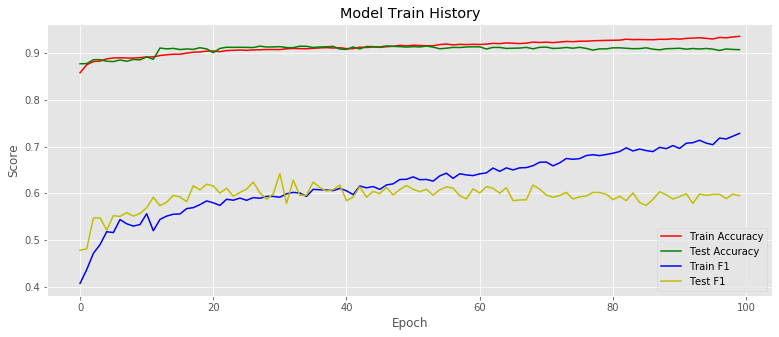

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Electronics,70.70,66.99,82.71,74.02,70.21,0.29,0.71,1981,2019
1,Refrigerator,66.15,66.06,38.92,48.98,61.83,0.34,0.62,2330,1670
2,Dishwasher,98.98,0.00,0.00,0.00,49.74,0.01,0.50,3967,33
3,Furnace,98.25,11.48,30.43,16.67,57.89,0.02,0.65,3977,23
4,Washer Dryer 1,98.82,70.37,71.25,70.81,85.10,0.01,0.85,3920,80
5,Washer Dryer 2,96.62,48.10,58.91,52.96,75.61,0.03,0.78,3871,129
6,Microwave,99.52,0.00,0.00,0.00,49.88,0.00,0.50,3981,19
7,Bathroom GFI,99.02,0.00,0.00,0.00,49.76,0.01,0.50,3961,39
8,Kitchen Outlets,88.90,25.00,1.15,2.20,48.16,0.11,0.50,3566,434



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,90.77,32.00,31.49,29.52,60.91,0.09,0.62,3506.0,494.0
max,99.52,70.37,82.71,74.02,85.10,0.34,0.85,3981.0,2019.0
min,66.15,0.00,0.00,0.00,48.16,0.00,0.50,1981.0,19.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - Electronics:
[[1158  823]
 [ 349 1670]]

 - Refrigerator:
[[1996  334]
 [1020  650]]

 - Dishwasher:
[[3959    8]
 [  33    0]]

 - Furnace:
[[3923   54]
 [  16    7]]

 - Washer Dryer 1:
[[3896   24]
 [  23   57]]

 - Washer Dryer 2:
[[3789   82]
 [  53   76]]

 - Microwave:
[[3981    0]
 [  19    0]]

 - Bathroom GFI:
[[3961    0]
 [  39    0]]

 - Kitchen Outlets:
[[3551   15]
 [ 429    5]]


In [25]:
# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(model_h4.predict(Xh4_test).round())
classification_report(y_test, y_pred, labels = appliance_labels)

# Conclusões

A utilização de RPs para a classificação multirótulo de cargas, seja utilizando classificadores tradicionais ou DL, demonstra os melhores resultados considerando **Acurácia e F1**.

Para continuidade dos estudos, vamos avaliar a estratégia de construir classificadores especialistas (binários) para cada carga, utilizando modelos baseado em DL (CNN - e CapsNet, se possível), considerando tanto GAF quanto RPs.